# SRCNN Paper Reproduction

In [1]:
import tensorflow as tf

flags

In [2]:
flags = tf.compat.v1.flags
flags.DEFINE_integer("epoch", 5, "Number of epoch [1000]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [128]")
flags.DEFINE_integer("image_size", 33, "The size of image to use [33]")
flags.DEFINE_integer("label_size", 21, "The size of label to produce [21]")
flags.DEFINE_float("learning_rate", 1e-4, "The learning rate of gradient descent algorithm [1e-4]")
flags.DEFINE_integer("c_dim", 1, "Dimension of image color. [1]")
flags.DEFINE_integer("scale", 3, "The size of scale factor for preprocessing input image [3]")
flags.DEFINE_integer("stride", 14, "The size of stride to apply input image [14]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Name of checkpoint directory [checkpoint]")
flags.DEFINE_string("sample_dir", "sample", "Name of sample directory [sample]")
flags.DEFINE_string("train_dir", "Train", "Name of training set directory")
flags.DEFINE_boolean("is_train", True, "True for training, False for testing [True]")
FLAGS = flags.FLAGS

In [3]:
import os
import glob
import sys
sys.argv = sys.argv[:1]
data_dir = os.path.join(os.getcwd(), FLAGS.train_dir)
# print(data_dir)
data = glob.glob(os.path.join(data_dir, "*.bmp"))
# print(data)

pre-processing

In [4]:
import imageio

# def prepare_data(sess, dataset):
#     """
#       Args:
#         dataset: choose train dataset or test dataset
    
#         For train dataset, output data would be ['.../t1.bmp', '.../t2.bmp', ..., '.../t99.bmp']
#     """
#     if FLAGS.is_train:
#         filenames = os.listdir(dataset)
#         data_dir = os.path.join(os.getcwd(), dataset)
#         data = glob.glob(os.path.join(data_dir, "*.bmp"))
#     else:
#         data_dir = os.path.join(os.sep, (os.path.join(os.getcwd(), dataset)), "Set5")
#         data = glob.glob(os.path.join(data_dir, "*.bmp"))

#     return data

In [5]:
# read *.bmp files
def read_data(path, is_grayscale=True):
    if is_grayscale:
        return imageio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float)
    else:
        return imageio.imread(path, pilmode='YCbCr').astype(np.float)    

In [6]:
def modcrop(image, scale=3):
    '''
    To scale down and up the original img, first thing to do is to have no remainder while scaling operation
    '''
    if len(image.shape)==3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:   
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image    

In [7]:
import scipy.misc
def preprocess(path, scale=3):   
    """
      Preprocess single image file 
        (1) Read original image as YCbCr format (and grayscale as default)
        (2) Normalize
        (3) Apply image file with bicubic interpolation
      Args:
        path: file path of desired file
        input_: image applied bicubic interpolation (low-resolution)
        label_: image with original resolution (high-resolution) 
    """
    image = read_data(path, is_grayscale=True)
    label_ = modcrop(image, scale)

  # Must be normalized
    image = image / 255.
    label_ = label_ / 255.


    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
      # so that bicubic is applied
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

    return input_, label_

Display input and groundtruth

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

91
(288, 411)
(288, 411)


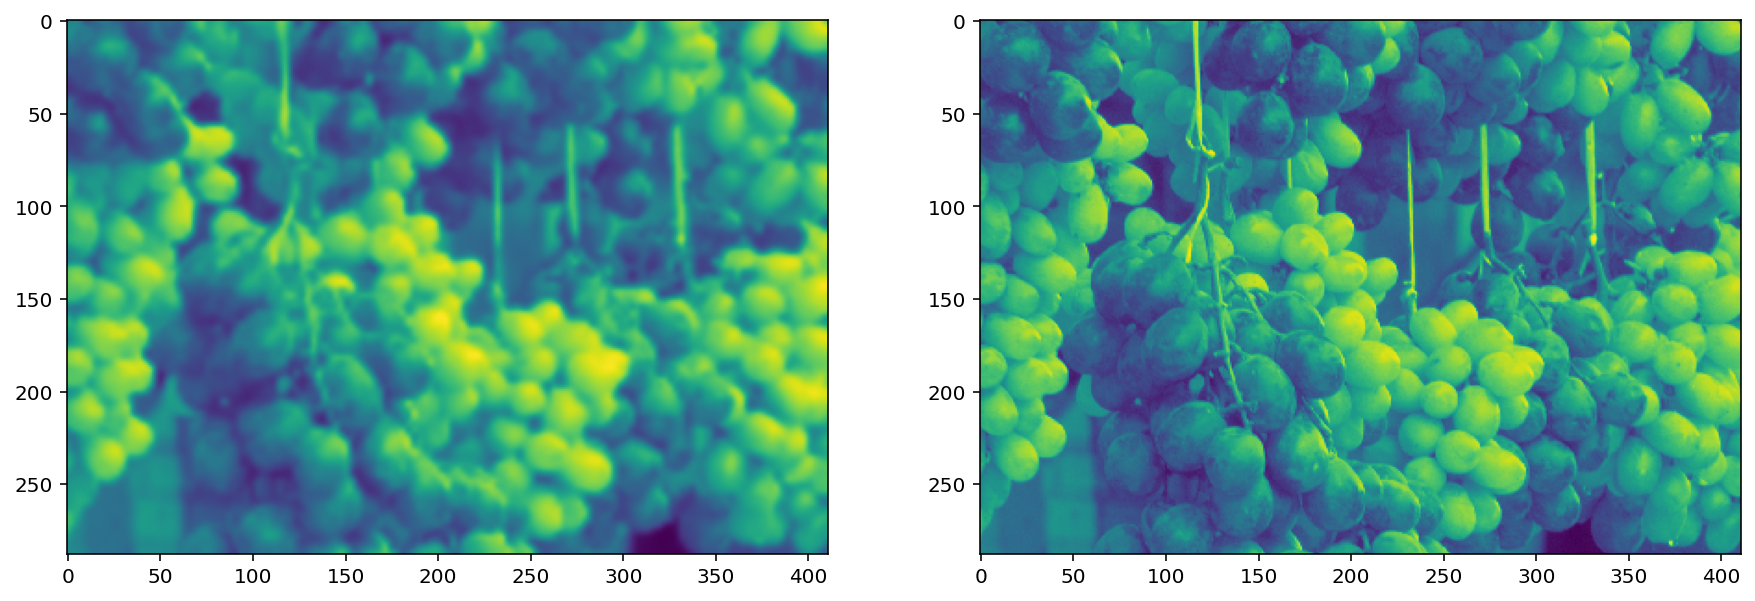

In [9]:
import numpy as np
print(len(data))
input_, label_ = preprocess(data[0], FLAGS.scale)
plt.figure(figsize=(15,15))
for i, image in enumerate([input_, label_]):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    print(image.shape)

Read image files and make their sub-image and save 

In [10]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(FLAGS.image_size - FLAGS.label_size)/2)
for i in range(len(data)):
    if i%10 == 0:
        input_, label_ = preprocess(data[i], FLAGS.scale)
        if len(input_.shape) == 3:
            h, w, _ = input_.shape
        else:
            h, w = input_.shape
        for x in range(0, h-FLAGS.image_size+1, FLAGS.stride):
            for y in range(0, w-FLAGS.image_size+1, FLAGS.stride):
                sub_input = input_[x:x+FLAGS.image_size, y:y+FLAGS.image_size] # 31*31
                sub_label = label_[x+padding:x+padding+FLAGS.label_size, y+padding:y+padding+FLAGS.label_size] # 21*21
                
                # Add Channel Value
                sub_input = sub_input.reshape([FLAGS.image_size, FLAGS.image_size, 1])
                sub_label = sub_label.reshape([FLAGS.label_size, FLAGS.label_size, 1])
                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)

In [11]:
"""
the number of sub_input (33*33*ch) in one img
"""
len(sub_input_sequence)
len(sub_label_sequence)

2736

In [12]:
"""
Make list to numpy array
"""
arrdata = np.asarray(sub_input_sequence)
arrlabel = np.asarray(sub_label_sequence)

In [13]:
arrdata.shape

(2736, 33, 33, 1)

In [14]:
import h5py
"""
Make input data as h5 file format
"""
if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
savepath = os.path.join(os.getcwd(), FLAGS.checkpoint_dir, 'train.h5')    
with h5py.File(savepath, 'w') as hf:
    hf.create_dataset('data', data=arrdata)
    hf.create_dataset('label', data=arrlabel)

# checkpoint
The preprocessed data has been saved to disk, 
and we get the data use the following method.

In [15]:
data_dir = os.path.join('./{}'.format('checkpoint'), "train.h5")

def get_data(path):
    with h5py.File(path, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label
train_data, train_label = get_data(data_dir)    

# Build the network

In [32]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

"""
Inputs:
"""
images = tf.placeholder(tf.float32,[None, FLAGS.image_size, FLAGS.image_size, FLAGS.c_dim], name='images')
labels = tf.placeholder(tf.float32, [None, FLAGS.label_size, FLAGS.label_size, FLAGS.c_dim], name='labels')

"""
Weights and Biases
"""
weights={
    'w1': tf.Variable(tf.random_normal([9,9,1,64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5,5,32,1], stddev=1e-3), name='w3')
}
biases={
    'b1': tf.Variable(tf.zeros([64]), name='b1'),
    'b2': tf.Variable(tf.zeros([32]), name='b2'),
    'b3': tf.Variable(tf.zeros([1]), name='b3')
}

In [35]:
"""
Model
"""
conv1 = tf.nn.relu(tf.nn.conv2d(images,
                               weights['w1'],
                               strides=[1,1,1,1],
                               padding='VALID')+biases['b1'])

conv2 = tf.nn.relu(tf.nn.conv2d(conv1,
                               weights['w2'],
                               strides=[1,1,1,1],
                               padding='VALID')+biases['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2,
                               weights['w3'],
                               strides=[1,1,1,1],
                               padding='VALID')+biases['b3'])
pred = conv3

In [36]:
"""
Loss Function (MSE)
"""
loss = tf.reduce_mean(tf.square(labels-pred))
saver = tf.train.Saver()

# Train the Network

In [38]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate).minimize(loss)

In [45]:
import time
print('Checking the Training on a single batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    counter = 0
    start_time = time.time()
    
    for ep in range(FLAGS.epoch):
        batch_idxs = len(train_data) #batch_size
        for idx in range(0, batch_idxs):
            batch_images = train_data[idx*FLAGS.batch_size:(idx+1)*FLAGS.batch_size]
            batch_labels = train_label[idx*FLAGS.batch_size:(idx+1)*FLAGS.batch_size]
            counter+=1
            _, err = sess.run([train_op, loss], feed_dict={images:batch_images, labels:batch_labels})
            
            print("Epoch:[%2d], step:[%2d], time:[%4.4f], loss:[%.8f]"%((ep+1), counter, time.time()-start_time, err))
            if counter % 20 == 0:
                model_name = 'SRCNN.model'
                model_dir = "%s_%s" % ("srcnn", FLAGS.label_size)
                FLAGS.checkpoint_dir = os.path.join('checkpoint', model_dir)
                
                if not os.path.exists(FLAGS.checkpoint_dir):
                    os.makedirs(FLAGS.checkpoint_dir)
                saver.save(sess, os.path.join(FLAGS.checkpoint_dir, model_name), global_step=counter)
            

Checking the Training on a single batch...
Epoch:[ 1], step:[ 1], time:[0.1997], loss:[0.21047440]
Epoch:[ 1], step:[ 2], time:[0.3476], loss:[0.27713320]
Epoch:[ 1], step:[ 3], time:[0.4890], loss:[0.35580727]
Epoch:[ 1], step:[ 4], time:[0.6261], loss:[0.27312258]
Epoch:[ 1], step:[ 5], time:[0.7738], loss:[0.26439181]
Epoch:[ 1], step:[ 6], time:[0.9108], loss:[0.22572583]
Epoch:[ 1], step:[ 7], time:[1.0595], loss:[0.29881483]
Epoch:[ 1], step:[ 8], time:[1.1953], loss:[0.46358708]
Epoch:[ 1], step:[ 9], time:[1.3376], loss:[0.34766966]
Epoch:[ 1], step:[10], time:[1.4823], loss:[0.32846591]
Epoch:[ 1], step:[11], time:[1.6452], loss:[0.35678783]
Epoch:[ 1], step:[12], time:[1.7981], loss:[0.25661993]
Epoch:[ 1], step:[13], time:[1.9392], loss:[0.28353533]
Epoch:[ 1], step:[14], time:[2.0790], loss:[0.20480870]
Epoch:[ 1], step:[15], time:[2.2239], loss:[0.26746193]
Epoch:[ 1], step:[16], time:[2.3633], loss:[0.26466906]
Epoch:[ 1], step:[17], time:[2.5063], loss:[0.27556574]
Epoch

Epoch:[ 1], step:[161], time:[4.0227], loss:[nan]
Epoch:[ 1], step:[162], time:[4.0269], loss:[nan]
Epoch:[ 1], step:[163], time:[4.0309], loss:[nan]
Epoch:[ 1], step:[164], time:[4.0353], loss:[nan]
Epoch:[ 1], step:[165], time:[4.0392], loss:[nan]
Epoch:[ 1], step:[166], time:[4.0429], loss:[nan]
Epoch:[ 1], step:[167], time:[4.0479], loss:[nan]
Epoch:[ 1], step:[168], time:[4.0512], loss:[nan]
Epoch:[ 1], step:[169], time:[4.0559], loss:[nan]
Epoch:[ 1], step:[170], time:[4.0595], loss:[nan]
Epoch:[ 1], step:[171], time:[4.0644], loss:[nan]
Epoch:[ 1], step:[172], time:[4.0680], loss:[nan]
Epoch:[ 1], step:[173], time:[4.0717], loss:[nan]
Epoch:[ 1], step:[174], time:[4.0752], loss:[nan]
Epoch:[ 1], step:[175], time:[4.0789], loss:[nan]
Epoch:[ 1], step:[176], time:[4.0822], loss:[nan]
Epoch:[ 1], step:[177], time:[4.0858], loss:[nan]
Epoch:[ 1], step:[178], time:[4.0897], loss:[nan]
Epoch:[ 1], step:[179], time:[4.0930], loss:[nan]
Epoch:[ 1], step:[180], time:[4.0968], loss:[nan]


Epoch:[ 1], step:[351], time:[5.1689], loss:[nan]
Epoch:[ 1], step:[352], time:[5.1741], loss:[nan]
Epoch:[ 1], step:[353], time:[5.1808], loss:[nan]
Epoch:[ 1], step:[354], time:[5.1849], loss:[nan]
Epoch:[ 1], step:[355], time:[5.1913], loss:[nan]
Epoch:[ 1], step:[356], time:[5.1963], loss:[nan]
Epoch:[ 1], step:[357], time:[5.2009], loss:[nan]
Epoch:[ 1], step:[358], time:[5.2078], loss:[nan]
Epoch:[ 1], step:[359], time:[5.2151], loss:[nan]
Epoch:[ 1], step:[360], time:[5.2197], loss:[nan]
Epoch:[ 1], step:[361], time:[5.2700], loss:[nan]
Epoch:[ 1], step:[362], time:[5.2755], loss:[nan]
Epoch:[ 1], step:[363], time:[5.2806], loss:[nan]
Epoch:[ 1], step:[364], time:[5.2850], loss:[nan]
Epoch:[ 1], step:[365], time:[5.2913], loss:[nan]
Epoch:[ 1], step:[366], time:[5.2951], loss:[nan]
Epoch:[ 1], step:[367], time:[5.3010], loss:[nan]
Epoch:[ 1], step:[368], time:[5.3066], loss:[nan]
Epoch:[ 1], step:[369], time:[5.3129], loss:[nan]
Epoch:[ 1], step:[370], time:[5.3193], loss:[nan]


Epoch:[ 1], step:[521], time:[6.2817], loss:[nan]
Epoch:[ 1], step:[522], time:[6.2867], loss:[nan]
Epoch:[ 1], step:[523], time:[6.2905], loss:[nan]
Epoch:[ 1], step:[524], time:[6.2949], loss:[nan]
Epoch:[ 1], step:[525], time:[6.2985], loss:[nan]
Epoch:[ 1], step:[526], time:[6.3031], loss:[nan]
Epoch:[ 1], step:[527], time:[6.3067], loss:[nan]
Epoch:[ 1], step:[528], time:[6.3109], loss:[nan]
Epoch:[ 1], step:[529], time:[6.3144], loss:[nan]
Epoch:[ 1], step:[530], time:[6.3190], loss:[nan]
Epoch:[ 1], step:[531], time:[6.3227], loss:[nan]
Epoch:[ 1], step:[532], time:[6.3270], loss:[nan]
Epoch:[ 1], step:[533], time:[6.3306], loss:[nan]
Epoch:[ 1], step:[534], time:[6.3351], loss:[nan]
Epoch:[ 1], step:[535], time:[6.3387], loss:[nan]
Epoch:[ 1], step:[536], time:[6.3435], loss:[nan]
Epoch:[ 1], step:[537], time:[6.3482], loss:[nan]
Epoch:[ 1], step:[538], time:[6.3528], loss:[nan]
Epoch:[ 1], step:[539], time:[6.3564], loss:[nan]
Epoch:[ 1], step:[540], time:[6.3610], loss:[nan]


Epoch:[ 1], step:[697], time:[7.3957], loss:[nan]
Epoch:[ 1], step:[698], time:[7.4010], loss:[nan]
Epoch:[ 1], step:[699], time:[7.4068], loss:[nan]
Epoch:[ 1], step:[700], time:[7.4106], loss:[nan]
Epoch:[ 1], step:[701], time:[7.4572], loss:[nan]
Epoch:[ 1], step:[702], time:[7.4608], loss:[nan]
Epoch:[ 1], step:[703], time:[7.4652], loss:[nan]
Epoch:[ 1], step:[704], time:[7.4703], loss:[nan]
Epoch:[ 1], step:[705], time:[7.4749], loss:[nan]
Epoch:[ 1], step:[706], time:[7.4805], loss:[nan]
Epoch:[ 1], step:[707], time:[7.4859], loss:[nan]
Epoch:[ 1], step:[708], time:[7.4908], loss:[nan]
Epoch:[ 1], step:[709], time:[7.4941], loss:[nan]
Epoch:[ 1], step:[710], time:[7.4986], loss:[nan]
Epoch:[ 1], step:[711], time:[7.5030], loss:[nan]
Epoch:[ 1], step:[712], time:[7.5077], loss:[nan]
Epoch:[ 1], step:[713], time:[7.5117], loss:[nan]
Epoch:[ 1], step:[714], time:[7.5155], loss:[nan]
Epoch:[ 1], step:[715], time:[7.5195], loss:[nan]
Epoch:[ 1], step:[716], time:[7.5229], loss:[nan]


Epoch:[ 1], step:[861], time:[8.4647], loss:[nan]
Epoch:[ 1], step:[862], time:[8.4700], loss:[nan]
Epoch:[ 1], step:[863], time:[8.4747], loss:[nan]
Epoch:[ 1], step:[864], time:[8.4800], loss:[nan]
Epoch:[ 1], step:[865], time:[8.4842], loss:[nan]
Epoch:[ 1], step:[866], time:[8.4876], loss:[nan]
Epoch:[ 1], step:[867], time:[8.4911], loss:[nan]
Epoch:[ 1], step:[868], time:[8.4948], loss:[nan]
Epoch:[ 1], step:[869], time:[8.4983], loss:[nan]
Epoch:[ 1], step:[870], time:[8.5021], loss:[nan]
Epoch:[ 1], step:[871], time:[8.5056], loss:[nan]
Epoch:[ 1], step:[872], time:[8.5103], loss:[nan]
Epoch:[ 1], step:[873], time:[8.5140], loss:[nan]
Epoch:[ 1], step:[874], time:[8.5177], loss:[nan]
Epoch:[ 1], step:[875], time:[8.5211], loss:[nan]
Epoch:[ 1], step:[876], time:[8.5247], loss:[nan]
Epoch:[ 1], step:[877], time:[8.5288], loss:[nan]
Epoch:[ 1], step:[878], time:[8.5333], loss:[nan]
Epoch:[ 1], step:[879], time:[8.5369], loss:[nan]
Epoch:[ 1], step:[880], time:[8.5411], loss:[nan]


Epoch:[ 1], step:[1038], time:[9.7620], loss:[nan]
Epoch:[ 1], step:[1039], time:[9.7694], loss:[nan]
Epoch:[ 1], step:[1040], time:[9.7753], loss:[nan]
Epoch:[ 1], step:[1041], time:[9.8626], loss:[nan]
Epoch:[ 1], step:[1042], time:[9.8683], loss:[nan]
Epoch:[ 1], step:[1043], time:[9.8728], loss:[nan]
Epoch:[ 1], step:[1044], time:[9.8775], loss:[nan]
Epoch:[ 1], step:[1045], time:[9.8813], loss:[nan]
Epoch:[ 1], step:[1046], time:[9.8872], loss:[nan]
Epoch:[ 1], step:[1047], time:[9.8936], loss:[nan]
Epoch:[ 1], step:[1048], time:[9.8994], loss:[nan]
Epoch:[ 1], step:[1049], time:[9.9045], loss:[nan]
Epoch:[ 1], step:[1050], time:[9.9096], loss:[nan]
Epoch:[ 1], step:[1051], time:[9.9147], loss:[nan]
Epoch:[ 1], step:[1052], time:[9.9204], loss:[nan]
Epoch:[ 1], step:[1053], time:[9.9256], loss:[nan]
Epoch:[ 1], step:[1054], time:[9.9303], loss:[nan]
Epoch:[ 1], step:[1055], time:[9.9348], loss:[nan]
Epoch:[ 1], step:[1056], time:[9.9396], loss:[nan]
Epoch:[ 1], step:[1057], time:[

Epoch:[ 1], step:[1199], time:[10.8568], loss:[nan]
Epoch:[ 1], step:[1200], time:[10.8624], loss:[nan]
Epoch:[ 1], step:[1201], time:[10.9092], loss:[nan]
Epoch:[ 1], step:[1202], time:[10.9136], loss:[nan]
Epoch:[ 1], step:[1203], time:[10.9175], loss:[nan]
Epoch:[ 1], step:[1204], time:[10.9221], loss:[nan]
Epoch:[ 1], step:[1205], time:[10.9259], loss:[nan]
Epoch:[ 1], step:[1206], time:[10.9307], loss:[nan]
Epoch:[ 1], step:[1207], time:[10.9349], loss:[nan]
Epoch:[ 1], step:[1208], time:[10.9394], loss:[nan]
Epoch:[ 1], step:[1209], time:[10.9443], loss:[nan]
Epoch:[ 1], step:[1210], time:[10.9487], loss:[nan]
Epoch:[ 1], step:[1211], time:[10.9528], loss:[nan]
Epoch:[ 1], step:[1212], time:[10.9567], loss:[nan]
Epoch:[ 1], step:[1213], time:[10.9619], loss:[nan]
Epoch:[ 1], step:[1214], time:[10.9661], loss:[nan]
Epoch:[ 1], step:[1215], time:[10.9701], loss:[nan]
Epoch:[ 1], step:[1216], time:[10.9741], loss:[nan]
Epoch:[ 1], step:[1217], time:[10.9780], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[1375], time:[12.1269], loss:[nan]
Epoch:[ 1], step:[1376], time:[12.1342], loss:[nan]
Epoch:[ 1], step:[1377], time:[12.1401], loss:[nan]
Epoch:[ 1], step:[1378], time:[12.1450], loss:[nan]
Epoch:[ 1], step:[1379], time:[12.1513], loss:[nan]
Epoch:[ 1], step:[1380], time:[12.1564], loss:[nan]
Epoch:[ 1], step:[1381], time:[12.2063], loss:[nan]
Epoch:[ 1], step:[1382], time:[12.2104], loss:[nan]
Epoch:[ 1], step:[1383], time:[12.2139], loss:[nan]
Epoch:[ 1], step:[1384], time:[12.2178], loss:[nan]
Epoch:[ 1], step:[1385], time:[12.2220], loss:[nan]
Epoch:[ 1], step:[1386], time:[12.2256], loss:[nan]
Epoch:[ 1], step:[1387], time:[12.2307], loss:[nan]
Epoch:[ 1], step:[1388], time:[12.2349], loss:[nan]
Epoch:[ 1], step:[1389], time:[12.2389], loss:[nan]
Epoch:[ 1], step:[1390], time:[12.2426], loss:[nan]
Epoch:[ 1], step:[1391], time:[12.2465], loss:[nan]
Epoch:[ 1], step:[1392], time:[12.2512], loss:[nan]
Epoch:[ 1], step:[1393], time:[12.2552], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[1550], time:[13.4346], loss:[nan]
Epoch:[ 1], step:[1551], time:[13.4412], loss:[nan]
Epoch:[ 1], step:[1552], time:[13.4452], loss:[nan]
Epoch:[ 1], step:[1553], time:[13.4493], loss:[nan]
Epoch:[ 1], step:[1554], time:[13.4539], loss:[nan]
Epoch:[ 1], step:[1555], time:[13.4579], loss:[nan]
Epoch:[ 1], step:[1556], time:[13.4617], loss:[nan]
Epoch:[ 1], step:[1557], time:[13.4660], loss:[nan]
Epoch:[ 1], step:[1558], time:[13.4699], loss:[nan]
Epoch:[ 1], step:[1559], time:[13.4757], loss:[nan]
Epoch:[ 1], step:[1560], time:[13.4792], loss:[nan]
Epoch:[ 1], step:[1561], time:[13.5588], loss:[nan]
Epoch:[ 1], step:[1562], time:[13.5646], loss:[nan]
Epoch:[ 1], step:[1563], time:[13.5696], loss:[nan]
Epoch:[ 1], step:[1564], time:[13.5820], loss:[nan]
Epoch:[ 1], step:[1565], time:[13.5885], loss:[nan]
Epoch:[ 1], step:[1566], time:[13.5994], loss:[nan]
Epoch:[ 1], step:[1567], time:[13.6051], loss:[nan]
Epoch:[ 1], step:[1568], time:[13.6116], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[1720], time:[14.6716], loss:[nan]
Epoch:[ 1], step:[1721], time:[14.7151], loss:[nan]
Epoch:[ 1], step:[1722], time:[14.7192], loss:[nan]
Epoch:[ 1], step:[1723], time:[14.7240], loss:[nan]
Epoch:[ 1], step:[1724], time:[14.7281], loss:[nan]
Epoch:[ 1], step:[1725], time:[14.7316], loss:[nan]
Epoch:[ 1], step:[1726], time:[14.7357], loss:[nan]
Epoch:[ 1], step:[1727], time:[14.7391], loss:[nan]
Epoch:[ 1], step:[1728], time:[14.7432], loss:[nan]
Epoch:[ 1], step:[1729], time:[14.7483], loss:[nan]
Epoch:[ 1], step:[1730], time:[14.7526], loss:[nan]
Epoch:[ 1], step:[1731], time:[14.7567], loss:[nan]
Epoch:[ 1], step:[1732], time:[14.7606], loss:[nan]
Epoch:[ 1], step:[1733], time:[14.7664], loss:[nan]
Epoch:[ 1], step:[1734], time:[14.7701], loss:[nan]
Epoch:[ 1], step:[1735], time:[14.7747], loss:[nan]
Epoch:[ 1], step:[1736], time:[14.7792], loss:[nan]
Epoch:[ 1], step:[1737], time:[14.7841], loss:[nan]
Epoch:[ 1], step:[1738], time:[14.7880], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[1881], time:[15.7374], loss:[nan]
Epoch:[ 1], step:[1882], time:[15.7427], loss:[nan]
Epoch:[ 1], step:[1883], time:[15.7469], loss:[nan]
Epoch:[ 1], step:[1884], time:[15.7507], loss:[nan]
Epoch:[ 1], step:[1885], time:[15.7550], loss:[nan]
Epoch:[ 1], step:[1886], time:[15.7593], loss:[nan]
Epoch:[ 1], step:[1887], time:[15.7629], loss:[nan]
Epoch:[ 1], step:[1888], time:[15.7663], loss:[nan]
Epoch:[ 1], step:[1889], time:[15.7701], loss:[nan]
Epoch:[ 1], step:[1890], time:[15.7736], loss:[nan]
Epoch:[ 1], step:[1891], time:[15.7772], loss:[nan]
Epoch:[ 1], step:[1892], time:[15.7807], loss:[nan]
Epoch:[ 1], step:[1893], time:[15.7843], loss:[nan]
Epoch:[ 1], step:[1894], time:[15.7877], loss:[nan]
Epoch:[ 1], step:[1895], time:[15.7916], loss:[nan]
Epoch:[ 1], step:[1896], time:[15.7951], loss:[nan]
Epoch:[ 1], step:[1897], time:[15.7985], loss:[nan]
Epoch:[ 1], step:[1898], time:[15.8020], loss:[nan]
Epoch:[ 1], step:[1899], time:[15.8055], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[2041], time:[16.6364], loss:[nan]
Epoch:[ 1], step:[2042], time:[16.6407], loss:[nan]
Epoch:[ 1], step:[2043], time:[16.6442], loss:[nan]
Epoch:[ 1], step:[2044], time:[16.6485], loss:[nan]
Epoch:[ 1], step:[2045], time:[16.6522], loss:[nan]
Epoch:[ 1], step:[2046], time:[16.6567], loss:[nan]
Epoch:[ 1], step:[2047], time:[16.6602], loss:[nan]
Epoch:[ 1], step:[2048], time:[16.6640], loss:[nan]
Epoch:[ 1], step:[2049], time:[16.6675], loss:[nan]
Epoch:[ 1], step:[2050], time:[16.6726], loss:[nan]
Epoch:[ 1], step:[2051], time:[16.6768], loss:[nan]
Epoch:[ 1], step:[2052], time:[16.6809], loss:[nan]
Epoch:[ 1], step:[2053], time:[16.6842], loss:[nan]
Epoch:[ 1], step:[2054], time:[16.6887], loss:[nan]
Epoch:[ 1], step:[2055], time:[16.6928], loss:[nan]
Epoch:[ 1], step:[2056], time:[16.6965], loss:[nan]
Epoch:[ 1], step:[2057], time:[16.7002], loss:[nan]
Epoch:[ 1], step:[2058], time:[16.7039], loss:[nan]
Epoch:[ 1], step:[2059], time:[16.7072], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[2201], time:[17.5578], loss:[nan]
Epoch:[ 1], step:[2202], time:[17.5618], loss:[nan]
Epoch:[ 1], step:[2203], time:[17.5653], loss:[nan]
Epoch:[ 1], step:[2204], time:[17.5689], loss:[nan]
Epoch:[ 1], step:[2205], time:[17.5727], loss:[nan]
Epoch:[ 1], step:[2206], time:[17.5771], loss:[nan]
Epoch:[ 1], step:[2207], time:[17.5819], loss:[nan]
Epoch:[ 1], step:[2208], time:[17.5862], loss:[nan]
Epoch:[ 1], step:[2209], time:[17.5906], loss:[nan]
Epoch:[ 1], step:[2210], time:[17.5946], loss:[nan]
Epoch:[ 1], step:[2211], time:[17.5986], loss:[nan]
Epoch:[ 1], step:[2212], time:[17.6033], loss:[nan]
Epoch:[ 1], step:[2213], time:[17.6072], loss:[nan]
Epoch:[ 1], step:[2214], time:[17.6108], loss:[nan]
Epoch:[ 1], step:[2215], time:[17.6146], loss:[nan]
Epoch:[ 1], step:[2216], time:[17.6180], loss:[nan]
Epoch:[ 1], step:[2217], time:[17.6220], loss:[nan]
Epoch:[ 1], step:[2218], time:[17.6262], loss:[nan]
Epoch:[ 1], step:[2219], time:[17.6300], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[2363], time:[18.5746], loss:[nan]
Epoch:[ 1], step:[2364], time:[18.5796], loss:[nan]
Epoch:[ 1], step:[2365], time:[18.5855], loss:[nan]
Epoch:[ 1], step:[2366], time:[18.5903], loss:[nan]
Epoch:[ 1], step:[2367], time:[18.5942], loss:[nan]
Epoch:[ 1], step:[2368], time:[18.6001], loss:[nan]
Epoch:[ 1], step:[2369], time:[18.6042], loss:[nan]
Epoch:[ 1], step:[2370], time:[18.6089], loss:[nan]
Epoch:[ 1], step:[2371], time:[18.6140], loss:[nan]
Epoch:[ 1], step:[2372], time:[18.6181], loss:[nan]
Epoch:[ 1], step:[2373], time:[18.6235], loss:[nan]
Epoch:[ 1], step:[2374], time:[18.6272], loss:[nan]
Epoch:[ 1], step:[2375], time:[18.6331], loss:[nan]
Epoch:[ 1], step:[2376], time:[18.6373], loss:[nan]
Epoch:[ 1], step:[2377], time:[18.6427], loss:[nan]
Epoch:[ 1], step:[2378], time:[18.6501], loss:[nan]
Epoch:[ 1], step:[2379], time:[18.6541], loss:[nan]
Epoch:[ 1], step:[2380], time:[18.6576], loss:[nan]
Epoch:[ 1], step:[2381], time:[18.7057], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[2541], time:[19.8311], loss:[nan]
Epoch:[ 1], step:[2542], time:[19.8377], loss:[nan]
Epoch:[ 1], step:[2543], time:[19.8430], loss:[nan]
Epoch:[ 1], step:[2544], time:[19.8467], loss:[nan]
Epoch:[ 1], step:[2545], time:[19.8511], loss:[nan]
Epoch:[ 1], step:[2546], time:[19.8545], loss:[nan]
Epoch:[ 1], step:[2547], time:[19.8590], loss:[nan]
Epoch:[ 1], step:[2548], time:[19.8626], loss:[nan]
Epoch:[ 1], step:[2549], time:[19.8662], loss:[nan]
Epoch:[ 1], step:[2550], time:[19.8697], loss:[nan]
Epoch:[ 1], step:[2551], time:[19.8734], loss:[nan]
Epoch:[ 1], step:[2552], time:[19.8786], loss:[nan]
Epoch:[ 1], step:[2553], time:[19.8825], loss:[nan]
Epoch:[ 1], step:[2554], time:[19.8859], loss:[nan]
Epoch:[ 1], step:[2555], time:[19.8898], loss:[nan]
Epoch:[ 1], step:[2556], time:[19.8956], loss:[nan]
Epoch:[ 1], step:[2557], time:[19.8999], loss:[nan]
Epoch:[ 1], step:[2558], time:[19.9041], loss:[nan]
Epoch:[ 1], step:[2559], time:[19.9082], loss:[nan]
Epoch:[ 1], 

Epoch:[ 1], step:[2721], time:[20.9320], loss:[nan]
Epoch:[ 1], step:[2722], time:[20.9363], loss:[nan]
Epoch:[ 1], step:[2723], time:[20.9403], loss:[nan]
Epoch:[ 1], step:[2724], time:[20.9445], loss:[nan]
Epoch:[ 1], step:[2725], time:[20.9494], loss:[nan]
Epoch:[ 1], step:[2726], time:[20.9530], loss:[nan]
Epoch:[ 1], step:[2727], time:[20.9570], loss:[nan]
Epoch:[ 1], step:[2728], time:[20.9613], loss:[nan]
Epoch:[ 1], step:[2729], time:[20.9653], loss:[nan]
Epoch:[ 1], step:[2730], time:[20.9691], loss:[nan]
Epoch:[ 1], step:[2731], time:[20.9733], loss:[nan]
Epoch:[ 1], step:[2732], time:[20.9770], loss:[nan]
Epoch:[ 1], step:[2733], time:[20.9805], loss:[nan]
Epoch:[ 1], step:[2734], time:[20.9847], loss:[nan]
Epoch:[ 1], step:[2735], time:[20.9883], loss:[nan]
Epoch:[ 1], step:[2736], time:[20.9919], loss:[nan]
Epoch:[ 2], step:[2737], time:[21.1482], loss:[0.20863906]
Epoch:[ 2], step:[2738], time:[21.2972], loss:[0.27500483]
Epoch:[ 2], step:[2739], time:[21.4723], loss:[0.3

Epoch:[ 2], step:[2901], time:[25.3159], loss:[nan]
Epoch:[ 2], step:[2902], time:[25.3204], loss:[nan]
Epoch:[ 2], step:[2903], time:[25.3247], loss:[nan]
Epoch:[ 2], step:[2904], time:[25.3300], loss:[nan]
Epoch:[ 2], step:[2905], time:[25.3349], loss:[nan]
Epoch:[ 2], step:[2906], time:[25.3387], loss:[nan]
Epoch:[ 2], step:[2907], time:[25.3421], loss:[nan]
Epoch:[ 2], step:[2908], time:[25.3460], loss:[nan]
Epoch:[ 2], step:[2909], time:[25.3506], loss:[nan]
Epoch:[ 2], step:[2910], time:[25.3549], loss:[nan]
Epoch:[ 2], step:[2911], time:[25.3585], loss:[nan]
Epoch:[ 2], step:[2912], time:[25.3623], loss:[nan]
Epoch:[ 2], step:[2913], time:[25.3659], loss:[nan]
Epoch:[ 2], step:[2914], time:[25.3706], loss:[nan]
Epoch:[ 2], step:[2915], time:[25.3741], loss:[nan]
Epoch:[ 2], step:[2916], time:[25.3778], loss:[nan]
Epoch:[ 2], step:[2917], time:[25.3812], loss:[nan]
Epoch:[ 2], step:[2918], time:[25.3851], loss:[nan]
Epoch:[ 2], step:[2919], time:[25.3885], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3061], time:[26.2449], loss:[nan]
Epoch:[ 2], step:[3062], time:[26.2498], loss:[nan]
Epoch:[ 2], step:[3063], time:[26.2548], loss:[nan]
Epoch:[ 2], step:[3064], time:[26.2586], loss:[nan]
Epoch:[ 2], step:[3065], time:[26.2623], loss:[nan]
Epoch:[ 2], step:[3066], time:[26.2657], loss:[nan]
Epoch:[ 2], step:[3067], time:[26.2699], loss:[nan]
Epoch:[ 2], step:[3068], time:[26.2733], loss:[nan]
Epoch:[ 2], step:[3069], time:[26.2786], loss:[nan]
Epoch:[ 2], step:[3070], time:[26.2823], loss:[nan]
Epoch:[ 2], step:[3071], time:[26.2879], loss:[nan]
Epoch:[ 2], step:[3072], time:[26.2922], loss:[nan]
Epoch:[ 2], step:[3073], time:[26.2958], loss:[nan]
Epoch:[ 2], step:[3074], time:[26.3002], loss:[nan]
Epoch:[ 2], step:[3075], time:[26.3035], loss:[nan]
Epoch:[ 2], step:[3076], time:[26.3077], loss:[nan]
Epoch:[ 2], step:[3077], time:[26.3114], loss:[nan]
Epoch:[ 2], step:[3078], time:[26.3154], loss:[nan]
Epoch:[ 2], step:[3079], time:[26.3189], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3221], time:[27.1906], loss:[nan]
Epoch:[ 2], step:[3222], time:[27.1944], loss:[nan]
Epoch:[ 2], step:[3223], time:[27.1986], loss:[nan]
Epoch:[ 2], step:[3224], time:[27.2020], loss:[nan]
Epoch:[ 2], step:[3225], time:[27.2070], loss:[nan]
Epoch:[ 2], step:[3226], time:[27.2105], loss:[nan]
Epoch:[ 2], step:[3227], time:[27.2145], loss:[nan]
Epoch:[ 2], step:[3228], time:[27.2197], loss:[nan]
Epoch:[ 2], step:[3229], time:[27.2238], loss:[nan]
Epoch:[ 2], step:[3230], time:[27.2270], loss:[nan]
Epoch:[ 2], step:[3231], time:[27.2311], loss:[nan]
Epoch:[ 2], step:[3232], time:[27.2346], loss:[nan]
Epoch:[ 2], step:[3233], time:[27.2384], loss:[nan]
Epoch:[ 2], step:[3234], time:[27.2420], loss:[nan]
Epoch:[ 2], step:[3235], time:[27.2461], loss:[nan]
Epoch:[ 2], step:[3236], time:[27.2495], loss:[nan]
Epoch:[ 2], step:[3237], time:[27.2536], loss:[nan]
Epoch:[ 2], step:[3238], time:[27.2573], loss:[nan]
Epoch:[ 2], step:[3239], time:[27.2612], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3401], time:[28.3429], loss:[nan]
Epoch:[ 2], step:[3402], time:[28.3467], loss:[nan]
Epoch:[ 2], step:[3403], time:[28.3512], loss:[nan]
Epoch:[ 2], step:[3404], time:[28.3559], loss:[nan]
Epoch:[ 2], step:[3405], time:[28.3613], loss:[nan]
Epoch:[ 2], step:[3406], time:[28.3646], loss:[nan]
Epoch:[ 2], step:[3407], time:[28.3693], loss:[nan]
Epoch:[ 2], step:[3408], time:[28.3727], loss:[nan]
Epoch:[ 2], step:[3409], time:[28.3792], loss:[nan]
Epoch:[ 2], step:[3410], time:[28.3837], loss:[nan]
Epoch:[ 2], step:[3411], time:[28.3877], loss:[nan]
Epoch:[ 2], step:[3412], time:[28.3925], loss:[nan]
Epoch:[ 2], step:[3413], time:[28.3966], loss:[nan]
Epoch:[ 2], step:[3414], time:[28.4010], loss:[nan]
Epoch:[ 2], step:[3415], time:[28.4044], loss:[nan]
Epoch:[ 2], step:[3416], time:[28.4082], loss:[nan]
Epoch:[ 2], step:[3417], time:[28.4115], loss:[nan]
Epoch:[ 2], step:[3418], time:[28.4148], loss:[nan]
Epoch:[ 2], step:[3419], time:[28.4186], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3561], time:[29.2438], loss:[nan]
Epoch:[ 2], step:[3562], time:[29.2482], loss:[nan]
Epoch:[ 2], step:[3563], time:[29.2517], loss:[nan]
Epoch:[ 2], step:[3564], time:[29.2561], loss:[nan]
Epoch:[ 2], step:[3565], time:[29.2598], loss:[nan]
Epoch:[ 2], step:[3566], time:[29.2648], loss:[nan]
Epoch:[ 2], step:[3567], time:[29.2687], loss:[nan]
Epoch:[ 2], step:[3568], time:[29.2731], loss:[nan]
Epoch:[ 2], step:[3569], time:[29.2772], loss:[nan]
Epoch:[ 2], step:[3570], time:[29.2807], loss:[nan]
Epoch:[ 2], step:[3571], time:[29.2844], loss:[nan]
Epoch:[ 2], step:[3572], time:[29.2879], loss:[nan]
Epoch:[ 2], step:[3573], time:[29.2917], loss:[nan]
Epoch:[ 2], step:[3574], time:[29.2951], loss:[nan]
Epoch:[ 2], step:[3575], time:[29.2987], loss:[nan]
Epoch:[ 2], step:[3576], time:[29.3021], loss:[nan]
Epoch:[ 2], step:[3577], time:[29.3053], loss:[nan]
Epoch:[ 2], step:[3578], time:[29.3091], loss:[nan]
Epoch:[ 2], step:[3579], time:[29.3125], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3721], time:[30.1476], loss:[nan]
Epoch:[ 2], step:[3722], time:[30.1524], loss:[nan]
Epoch:[ 2], step:[3723], time:[30.1559], loss:[nan]
Epoch:[ 2], step:[3724], time:[30.1604], loss:[nan]
Epoch:[ 2], step:[3725], time:[30.1655], loss:[nan]
Epoch:[ 2], step:[3726], time:[30.1689], loss:[nan]
Epoch:[ 2], step:[3727], time:[30.1741], loss:[nan]
Epoch:[ 2], step:[3728], time:[30.1779], loss:[nan]
Epoch:[ 2], step:[3729], time:[30.1822], loss:[nan]
Epoch:[ 2], step:[3730], time:[30.1856], loss:[nan]
Epoch:[ 2], step:[3731], time:[30.1906], loss:[nan]
Epoch:[ 2], step:[3732], time:[30.1945], loss:[nan]
Epoch:[ 2], step:[3733], time:[30.1980], loss:[nan]
Epoch:[ 2], step:[3734], time:[30.2014], loss:[nan]
Epoch:[ 2], step:[3735], time:[30.2061], loss:[nan]
Epoch:[ 2], step:[3736], time:[30.2094], loss:[nan]
Epoch:[ 2], step:[3737], time:[30.2130], loss:[nan]
Epoch:[ 2], step:[3738], time:[30.2166], loss:[nan]
Epoch:[ 2], step:[3739], time:[30.2201], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[3901], time:[31.2649], loss:[nan]
Epoch:[ 2], step:[3902], time:[31.2706], loss:[nan]
Epoch:[ 2], step:[3903], time:[31.2756], loss:[nan]
Epoch:[ 2], step:[3904], time:[31.2812], loss:[nan]
Epoch:[ 2], step:[3905], time:[31.2863], loss:[nan]
Epoch:[ 2], step:[3906], time:[31.2915], loss:[nan]
Epoch:[ 2], step:[3907], time:[31.2962], loss:[nan]
Epoch:[ 2], step:[3908], time:[31.3021], loss:[nan]
Epoch:[ 2], step:[3909], time:[31.3072], loss:[nan]
Epoch:[ 2], step:[3910], time:[31.3113], loss:[nan]
Epoch:[ 2], step:[3911], time:[31.3167], loss:[nan]
Epoch:[ 2], step:[3912], time:[31.3214], loss:[nan]
Epoch:[ 2], step:[3913], time:[31.3270], loss:[nan]
Epoch:[ 2], step:[3914], time:[31.3326], loss:[nan]
Epoch:[ 2], step:[3915], time:[31.3385], loss:[nan]
Epoch:[ 2], step:[3916], time:[31.3442], loss:[nan]
Epoch:[ 2], step:[3917], time:[31.3499], loss:[nan]
Epoch:[ 2], step:[3918], time:[31.3551], loss:[nan]
Epoch:[ 2], step:[3919], time:[31.3592], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4061], time:[32.3053], loss:[nan]
Epoch:[ 2], step:[4062], time:[32.3092], loss:[nan]
Epoch:[ 2], step:[4063], time:[32.3139], loss:[nan]
Epoch:[ 2], step:[4064], time:[32.3175], loss:[nan]
Epoch:[ 2], step:[4065], time:[32.3217], loss:[nan]
Epoch:[ 2], step:[4066], time:[32.3254], loss:[nan]
Epoch:[ 2], step:[4067], time:[32.3289], loss:[nan]
Epoch:[ 2], step:[4068], time:[32.3323], loss:[nan]
Epoch:[ 2], step:[4069], time:[32.3358], loss:[nan]
Epoch:[ 2], step:[4070], time:[32.3393], loss:[nan]
Epoch:[ 2], step:[4071], time:[32.3427], loss:[nan]
Epoch:[ 2], step:[4072], time:[32.3460], loss:[nan]
Epoch:[ 2], step:[4073], time:[32.3496], loss:[nan]
Epoch:[ 2], step:[4074], time:[32.3533], loss:[nan]
Epoch:[ 2], step:[4075], time:[32.3567], loss:[nan]
Epoch:[ 2], step:[4076], time:[32.3615], loss:[nan]
Epoch:[ 2], step:[4077], time:[32.3651], loss:[nan]
Epoch:[ 2], step:[4078], time:[32.3686], loss:[nan]
Epoch:[ 2], step:[4079], time:[32.3735], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4221], time:[33.1885], loss:[nan]
Epoch:[ 2], step:[4222], time:[33.1923], loss:[nan]
Epoch:[ 2], step:[4223], time:[33.1966], loss:[nan]
Epoch:[ 2], step:[4224], time:[33.2006], loss:[nan]
Epoch:[ 2], step:[4225], time:[33.2054], loss:[nan]
Epoch:[ 2], step:[4226], time:[33.2095], loss:[nan]
Epoch:[ 2], step:[4227], time:[33.2131], loss:[nan]
Epoch:[ 2], step:[4228], time:[33.2167], loss:[nan]
Epoch:[ 2], step:[4229], time:[33.2200], loss:[nan]
Epoch:[ 2], step:[4230], time:[33.2237], loss:[nan]
Epoch:[ 2], step:[4231], time:[33.2271], loss:[nan]
Epoch:[ 2], step:[4232], time:[33.2309], loss:[nan]
Epoch:[ 2], step:[4233], time:[33.2342], loss:[nan]
Epoch:[ 2], step:[4234], time:[33.2377], loss:[nan]
Epoch:[ 2], step:[4235], time:[33.2410], loss:[nan]
Epoch:[ 2], step:[4236], time:[33.2444], loss:[nan]
Epoch:[ 2], step:[4237], time:[33.2480], loss:[nan]
Epoch:[ 2], step:[4238], time:[33.2513], loss:[nan]
Epoch:[ 2], step:[4239], time:[33.2570], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4381], time:[34.1075], loss:[nan]
Epoch:[ 2], step:[4382], time:[34.1132], loss:[nan]
Epoch:[ 2], step:[4383], time:[34.1174], loss:[nan]
Epoch:[ 2], step:[4384], time:[34.1210], loss:[nan]
Epoch:[ 2], step:[4385], time:[34.1261], loss:[nan]
Epoch:[ 2], step:[4386], time:[34.1299], loss:[nan]
Epoch:[ 2], step:[4387], time:[34.1334], loss:[nan]
Epoch:[ 2], step:[4388], time:[34.1369], loss:[nan]
Epoch:[ 2], step:[4389], time:[34.1404], loss:[nan]
Epoch:[ 2], step:[4390], time:[34.1442], loss:[nan]
Epoch:[ 2], step:[4391], time:[34.1478], loss:[nan]
Epoch:[ 2], step:[4392], time:[34.1513], loss:[nan]
Epoch:[ 2], step:[4393], time:[34.1548], loss:[nan]
Epoch:[ 2], step:[4394], time:[34.1582], loss:[nan]
Epoch:[ 2], step:[4395], time:[34.1619], loss:[nan]
Epoch:[ 2], step:[4396], time:[34.1656], loss:[nan]
Epoch:[ 2], step:[4397], time:[34.1689], loss:[nan]
Epoch:[ 2], step:[4398], time:[34.1724], loss:[nan]
Epoch:[ 2], step:[4399], time:[34.1761], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4541], time:[35.2837], loss:[nan]
Epoch:[ 2], step:[4542], time:[35.2913], loss:[nan]
Epoch:[ 2], step:[4543], time:[35.2951], loss:[nan]
Epoch:[ 2], step:[4544], time:[35.2995], loss:[nan]
Epoch:[ 2], step:[4545], time:[35.3051], loss:[nan]
Epoch:[ 2], step:[4546], time:[35.3099], loss:[nan]
Epoch:[ 2], step:[4547], time:[35.3139], loss:[nan]
Epoch:[ 2], step:[4548], time:[35.3191], loss:[nan]
Epoch:[ 2], step:[4549], time:[35.3242], loss:[nan]
Epoch:[ 2], step:[4550], time:[35.3279], loss:[nan]
Epoch:[ 2], step:[4551], time:[35.3324], loss:[nan]
Epoch:[ 2], step:[4552], time:[35.3380], loss:[nan]
Epoch:[ 2], step:[4553], time:[35.3423], loss:[nan]
Epoch:[ 2], step:[4554], time:[35.3462], loss:[nan]
Epoch:[ 2], step:[4555], time:[35.3538], loss:[nan]
Epoch:[ 2], step:[4556], time:[35.3590], loss:[nan]
Epoch:[ 2], step:[4557], time:[35.3632], loss:[nan]
Epoch:[ 2], step:[4558], time:[35.3685], loss:[nan]
Epoch:[ 2], step:[4559], time:[35.3731], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4702], time:[36.3338], loss:[nan]
Epoch:[ 2], step:[4703], time:[36.3381], loss:[nan]
Epoch:[ 2], step:[4704], time:[36.3427], loss:[nan]
Epoch:[ 2], step:[4705], time:[36.3461], loss:[nan]
Epoch:[ 2], step:[4706], time:[36.3513], loss:[nan]
Epoch:[ 2], step:[4707], time:[36.3549], loss:[nan]
Epoch:[ 2], step:[4708], time:[36.3596], loss:[nan]
Epoch:[ 2], step:[4709], time:[36.3629], loss:[nan]
Epoch:[ 2], step:[4710], time:[36.3674], loss:[nan]
Epoch:[ 2], step:[4711], time:[36.3708], loss:[nan]
Epoch:[ 2], step:[4712], time:[36.3750], loss:[nan]
Epoch:[ 2], step:[4713], time:[36.3785], loss:[nan]
Epoch:[ 2], step:[4714], time:[36.3843], loss:[nan]
Epoch:[ 2], step:[4715], time:[36.3880], loss:[nan]
Epoch:[ 2], step:[4716], time:[36.3931], loss:[nan]
Epoch:[ 2], step:[4717], time:[36.3974], loss:[nan]
Epoch:[ 2], step:[4718], time:[36.4011], loss:[nan]
Epoch:[ 2], step:[4719], time:[36.4044], loss:[nan]
Epoch:[ 2], step:[4720], time:[36.4087], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[4887], time:[37.4343], loss:[nan]
Epoch:[ 2], step:[4888], time:[37.4384], loss:[nan]
Epoch:[ 2], step:[4889], time:[37.4425], loss:[nan]
Epoch:[ 2], step:[4890], time:[37.4460], loss:[nan]
Epoch:[ 2], step:[4891], time:[37.4510], loss:[nan]
Epoch:[ 2], step:[4892], time:[37.4544], loss:[nan]
Epoch:[ 2], step:[4893], time:[37.4592], loss:[nan]
Epoch:[ 2], step:[4894], time:[37.4629], loss:[nan]
Epoch:[ 2], step:[4895], time:[37.4673], loss:[nan]
Epoch:[ 2], step:[4896], time:[37.4708], loss:[nan]
Epoch:[ 2], step:[4897], time:[37.4754], loss:[nan]
Epoch:[ 2], step:[4898], time:[37.4792], loss:[nan]
Epoch:[ 2], step:[4899], time:[37.4834], loss:[nan]
Epoch:[ 2], step:[4900], time:[37.4869], loss:[nan]
Epoch:[ 2], step:[4901], time:[37.5347], loss:[nan]
Epoch:[ 2], step:[4902], time:[37.5394], loss:[nan]
Epoch:[ 2], step:[4903], time:[37.5435], loss:[nan]
Epoch:[ 2], step:[4904], time:[37.5480], loss:[nan]
Epoch:[ 2], step:[4905], time:[37.5517], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[5081], time:[38.6207], loss:[nan]
Epoch:[ 2], step:[5082], time:[38.6242], loss:[nan]
Epoch:[ 2], step:[5083], time:[38.6276], loss:[nan]
Epoch:[ 2], step:[5084], time:[38.6311], loss:[nan]
Epoch:[ 2], step:[5085], time:[38.6347], loss:[nan]
Epoch:[ 2], step:[5086], time:[38.6380], loss:[nan]
Epoch:[ 2], step:[5087], time:[38.6417], loss:[nan]
Epoch:[ 2], step:[5088], time:[38.6451], loss:[nan]
Epoch:[ 2], step:[5089], time:[38.6500], loss:[nan]
Epoch:[ 2], step:[5090], time:[38.6535], loss:[nan]
Epoch:[ 2], step:[5091], time:[38.6575], loss:[nan]
Epoch:[ 2], step:[5092], time:[38.6612], loss:[nan]
Epoch:[ 2], step:[5093], time:[38.6656], loss:[nan]
Epoch:[ 2], step:[5094], time:[38.6694], loss:[nan]
Epoch:[ 2], step:[5095], time:[38.6728], loss:[nan]
Epoch:[ 2], step:[5096], time:[38.6768], loss:[nan]
Epoch:[ 2], step:[5097], time:[38.6801], loss:[nan]
Epoch:[ 2], step:[5098], time:[38.6839], loss:[nan]
Epoch:[ 2], step:[5099], time:[38.6876], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[5241], time:[39.5060], loss:[nan]
Epoch:[ 2], step:[5242], time:[39.5097], loss:[nan]
Epoch:[ 2], step:[5243], time:[39.5132], loss:[nan]
Epoch:[ 2], step:[5244], time:[39.5169], loss:[nan]
Epoch:[ 2], step:[5245], time:[39.5206], loss:[nan]
Epoch:[ 2], step:[5246], time:[39.5241], loss:[nan]
Epoch:[ 2], step:[5247], time:[39.5281], loss:[nan]
Epoch:[ 2], step:[5248], time:[39.5318], loss:[nan]
Epoch:[ 2], step:[5249], time:[39.5354], loss:[nan]
Epoch:[ 2], step:[5250], time:[39.5387], loss:[nan]
Epoch:[ 2], step:[5251], time:[39.5424], loss:[nan]
Epoch:[ 2], step:[5252], time:[39.5465], loss:[nan]
Epoch:[ 2], step:[5253], time:[39.5499], loss:[nan]
Epoch:[ 2], step:[5254], time:[39.5534], loss:[nan]
Epoch:[ 2], step:[5255], time:[39.5572], loss:[nan]
Epoch:[ 2], step:[5256], time:[39.5607], loss:[nan]
Epoch:[ 2], step:[5257], time:[39.5644], loss:[nan]
Epoch:[ 2], step:[5258], time:[39.5680], loss:[nan]
Epoch:[ 2], step:[5259], time:[39.5721], loss:[nan]
Epoch:[ 2], 

Epoch:[ 2], step:[5401], time:[40.4246], loss:[nan]
Epoch:[ 2], step:[5402], time:[40.4284], loss:[nan]
Epoch:[ 2], step:[5403], time:[40.4320], loss:[nan]
Epoch:[ 2], step:[5404], time:[40.4360], loss:[nan]
Epoch:[ 2], step:[5405], time:[40.4396], loss:[nan]
Epoch:[ 2], step:[5406], time:[40.4430], loss:[nan]
Epoch:[ 2], step:[5407], time:[40.4470], loss:[nan]
Epoch:[ 2], step:[5408], time:[40.4503], loss:[nan]
Epoch:[ 2], step:[5409], time:[40.4538], loss:[nan]
Epoch:[ 2], step:[5410], time:[40.4576], loss:[nan]
Epoch:[ 2], step:[5411], time:[40.4609], loss:[nan]
Epoch:[ 2], step:[5412], time:[40.4646], loss:[nan]
Epoch:[ 2], step:[5413], time:[40.4681], loss:[nan]
Epoch:[ 2], step:[5414], time:[40.4717], loss:[nan]
Epoch:[ 2], step:[5415], time:[40.4752], loss:[nan]
Epoch:[ 2], step:[5416], time:[40.4788], loss:[nan]
Epoch:[ 2], step:[5417], time:[40.4822], loss:[nan]
Epoch:[ 2], step:[5418], time:[40.4855], loss:[nan]
Epoch:[ 2], step:[5419], time:[40.4891], loss:[nan]
Epoch:[ 2], 

Epoch:[ 3], step:[5561], time:[44.4790], loss:[nan]
Epoch:[ 3], step:[5562], time:[44.4830], loss:[nan]
Epoch:[ 3], step:[5563], time:[44.4866], loss:[nan]
Epoch:[ 3], step:[5564], time:[44.4903], loss:[nan]
Epoch:[ 3], step:[5565], time:[44.4947], loss:[nan]
Epoch:[ 3], step:[5566], time:[44.4983], loss:[nan]
Epoch:[ 3], step:[5567], time:[44.5020], loss:[nan]
Epoch:[ 3], step:[5568], time:[44.5058], loss:[nan]
Epoch:[ 3], step:[5569], time:[44.5094], loss:[nan]
Epoch:[ 3], step:[5570], time:[44.5127], loss:[nan]
Epoch:[ 3], step:[5571], time:[44.5163], loss:[nan]
Epoch:[ 3], step:[5572], time:[44.5198], loss:[nan]
Epoch:[ 3], step:[5573], time:[44.5235], loss:[nan]
Epoch:[ 3], step:[5574], time:[44.5280], loss:[nan]
Epoch:[ 3], step:[5575], time:[44.5314], loss:[nan]
Epoch:[ 3], step:[5576], time:[44.5359], loss:[nan]
Epoch:[ 3], step:[5577], time:[44.5399], loss:[nan]
Epoch:[ 3], step:[5578], time:[44.5434], loss:[nan]
Epoch:[ 3], step:[5579], time:[44.5471], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[5721], time:[45.3603], loss:[nan]
Epoch:[ 3], step:[5722], time:[45.3654], loss:[nan]
Epoch:[ 3], step:[5723], time:[45.3698], loss:[nan]
Epoch:[ 3], step:[5724], time:[45.3730], loss:[nan]
Epoch:[ 3], step:[5725], time:[45.3769], loss:[nan]
Epoch:[ 3], step:[5726], time:[45.3803], loss:[nan]
Epoch:[ 3], step:[5727], time:[45.3844], loss:[nan]
Epoch:[ 3], step:[5728], time:[45.3882], loss:[nan]
Epoch:[ 3], step:[5729], time:[45.3917], loss:[nan]
Epoch:[ 3], step:[5730], time:[45.3950], loss:[nan]
Epoch:[ 3], step:[5731], time:[45.3986], loss:[nan]
Epoch:[ 3], step:[5732], time:[45.4018], loss:[nan]
Epoch:[ 3], step:[5733], time:[45.4055], loss:[nan]
Epoch:[ 3], step:[5734], time:[45.4088], loss:[nan]
Epoch:[ 3], step:[5735], time:[45.4121], loss:[nan]
Epoch:[ 3], step:[5736], time:[45.4156], loss:[nan]
Epoch:[ 3], step:[5737], time:[45.4189], loss:[nan]
Epoch:[ 3], step:[5738], time:[45.4224], loss:[nan]
Epoch:[ 3], step:[5739], time:[45.4260], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[5881], time:[46.2418], loss:[nan]
Epoch:[ 3], step:[5882], time:[46.2460], loss:[nan]
Epoch:[ 3], step:[5883], time:[46.2496], loss:[nan]
Epoch:[ 3], step:[5884], time:[46.2534], loss:[nan]
Epoch:[ 3], step:[5885], time:[46.2575], loss:[nan]
Epoch:[ 3], step:[5886], time:[46.2608], loss:[nan]
Epoch:[ 3], step:[5887], time:[46.2643], loss:[nan]
Epoch:[ 3], step:[5888], time:[46.2677], loss:[nan]
Epoch:[ 3], step:[5889], time:[46.2712], loss:[nan]
Epoch:[ 3], step:[5890], time:[46.2746], loss:[nan]
Epoch:[ 3], step:[5891], time:[46.2779], loss:[nan]
Epoch:[ 3], step:[5892], time:[46.2816], loss:[nan]
Epoch:[ 3], step:[5893], time:[46.2852], loss:[nan]
Epoch:[ 3], step:[5894], time:[46.2885], loss:[nan]
Epoch:[ 3], step:[5895], time:[46.2923], loss:[nan]
Epoch:[ 3], step:[5896], time:[46.2959], loss:[nan]
Epoch:[ 3], step:[5897], time:[46.3003], loss:[nan]
Epoch:[ 3], step:[5898], time:[46.3042], loss:[nan]
Epoch:[ 3], step:[5899], time:[46.3077], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6041], time:[47.1194], loss:[nan]
Epoch:[ 3], step:[6042], time:[47.1235], loss:[nan]
Epoch:[ 3], step:[6043], time:[47.1288], loss:[nan]
Epoch:[ 3], step:[6044], time:[47.1329], loss:[nan]
Epoch:[ 3], step:[6045], time:[47.1368], loss:[nan]
Epoch:[ 3], step:[6046], time:[47.1408], loss:[nan]
Epoch:[ 3], step:[6047], time:[47.1451], loss:[nan]
Epoch:[ 3], step:[6048], time:[47.1485], loss:[nan]
Epoch:[ 3], step:[6049], time:[47.1527], loss:[nan]
Epoch:[ 3], step:[6050], time:[47.1564], loss:[nan]
Epoch:[ 3], step:[6051], time:[47.1599], loss:[nan]
Epoch:[ 3], step:[6052], time:[47.1637], loss:[nan]
Epoch:[ 3], step:[6053], time:[47.1671], loss:[nan]
Epoch:[ 3], step:[6054], time:[47.1708], loss:[nan]
Epoch:[ 3], step:[6055], time:[47.1745], loss:[nan]
Epoch:[ 3], step:[6056], time:[47.1780], loss:[nan]
Epoch:[ 3], step:[6057], time:[47.1814], loss:[nan]
Epoch:[ 3], step:[6058], time:[47.1848], loss:[nan]
Epoch:[ 3], step:[6059], time:[47.1886], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6201], time:[48.0018], loss:[nan]
Epoch:[ 3], step:[6202], time:[48.0057], loss:[nan]
Epoch:[ 3], step:[6203], time:[48.0097], loss:[nan]
Epoch:[ 3], step:[6204], time:[48.0132], loss:[nan]
Epoch:[ 3], step:[6205], time:[48.0173], loss:[nan]
Epoch:[ 3], step:[6206], time:[48.0208], loss:[nan]
Epoch:[ 3], step:[6207], time:[48.0244], loss:[nan]
Epoch:[ 3], step:[6208], time:[48.0281], loss:[nan]
Epoch:[ 3], step:[6209], time:[48.0314], loss:[nan]
Epoch:[ 3], step:[6210], time:[48.0348], loss:[nan]
Epoch:[ 3], step:[6211], time:[48.0385], loss:[nan]
Epoch:[ 3], step:[6212], time:[48.0449], loss:[nan]
Epoch:[ 3], step:[6213], time:[48.0506], loss:[nan]
Epoch:[ 3], step:[6214], time:[48.0560], loss:[nan]
Epoch:[ 3], step:[6215], time:[48.0606], loss:[nan]
Epoch:[ 3], step:[6216], time:[48.0641], loss:[nan]
Epoch:[ 3], step:[6217], time:[48.0696], loss:[nan]
Epoch:[ 3], step:[6218], time:[48.0733], loss:[nan]
Epoch:[ 3], step:[6219], time:[48.0769], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6360], time:[48.9092], loss:[nan]
Epoch:[ 3], step:[6361], time:[48.9591], loss:[nan]
Epoch:[ 3], step:[6362], time:[48.9632], loss:[nan]
Epoch:[ 3], step:[6363], time:[48.9684], loss:[nan]
Epoch:[ 3], step:[6364], time:[48.9726], loss:[nan]
Epoch:[ 3], step:[6365], time:[48.9769], loss:[nan]
Epoch:[ 3], step:[6366], time:[48.9814], loss:[nan]
Epoch:[ 3], step:[6367], time:[48.9856], loss:[nan]
Epoch:[ 3], step:[6368], time:[48.9898], loss:[nan]
Epoch:[ 3], step:[6369], time:[48.9942], loss:[nan]
Epoch:[ 3], step:[6370], time:[48.9994], loss:[nan]
Epoch:[ 3], step:[6371], time:[49.0042], loss:[nan]
Epoch:[ 3], step:[6372], time:[49.0090], loss:[nan]
Epoch:[ 3], step:[6373], time:[49.0137], loss:[nan]
Epoch:[ 3], step:[6374], time:[49.0191], loss:[nan]
Epoch:[ 3], step:[6375], time:[49.0237], loss:[nan]
Epoch:[ 3], step:[6376], time:[49.0283], loss:[nan]
Epoch:[ 3], step:[6377], time:[49.0328], loss:[nan]
Epoch:[ 3], step:[6378], time:[49.0374], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6541], time:[49.9790], loss:[nan]
Epoch:[ 3], step:[6542], time:[49.9834], loss:[nan]
Epoch:[ 3], step:[6543], time:[49.9869], loss:[nan]
Epoch:[ 3], step:[6544], time:[49.9913], loss:[nan]
Epoch:[ 3], step:[6545], time:[49.9954], loss:[nan]
Epoch:[ 3], step:[6546], time:[49.9989], loss:[nan]
Epoch:[ 3], step:[6547], time:[50.0025], loss:[nan]
Epoch:[ 3], step:[6548], time:[50.0058], loss:[nan]
Epoch:[ 3], step:[6549], time:[50.0093], loss:[nan]
Epoch:[ 3], step:[6550], time:[50.0129], loss:[nan]
Epoch:[ 3], step:[6551], time:[50.0162], loss:[nan]
Epoch:[ 3], step:[6552], time:[50.0200], loss:[nan]
Epoch:[ 3], step:[6553], time:[50.0234], loss:[nan]
Epoch:[ 3], step:[6554], time:[50.0272], loss:[nan]
Epoch:[ 3], step:[6555], time:[50.0306], loss:[nan]
Epoch:[ 3], step:[6556], time:[50.0339], loss:[nan]
Epoch:[ 3], step:[6557], time:[50.0383], loss:[nan]
Epoch:[ 3], step:[6558], time:[50.0422], loss:[nan]
Epoch:[ 3], step:[6559], time:[50.0457], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6701], time:[50.8598], loss:[nan]
Epoch:[ 3], step:[6702], time:[50.8645], loss:[nan]
Epoch:[ 3], step:[6703], time:[50.8687], loss:[nan]
Epoch:[ 3], step:[6704], time:[50.8731], loss:[nan]
Epoch:[ 3], step:[6705], time:[50.8768], loss:[nan]
Epoch:[ 3], step:[6706], time:[50.8805], loss:[nan]
Epoch:[ 3], step:[6707], time:[50.8840], loss:[nan]
Epoch:[ 3], step:[6708], time:[50.8872], loss:[nan]
Epoch:[ 3], step:[6709], time:[50.8906], loss:[nan]
Epoch:[ 3], step:[6710], time:[50.8941], loss:[nan]
Epoch:[ 3], step:[6711], time:[50.8977], loss:[nan]
Epoch:[ 3], step:[6712], time:[50.9013], loss:[nan]
Epoch:[ 3], step:[6713], time:[50.9046], loss:[nan]
Epoch:[ 3], step:[6714], time:[50.9082], loss:[nan]
Epoch:[ 3], step:[6715], time:[50.9118], loss:[nan]
Epoch:[ 3], step:[6716], time:[50.9153], loss:[nan]
Epoch:[ 3], step:[6717], time:[50.9189], loss:[nan]
Epoch:[ 3], step:[6718], time:[50.9221], loss:[nan]
Epoch:[ 3], step:[6719], time:[50.9258], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[6861], time:[51.7423], loss:[nan]
Epoch:[ 3], step:[6862], time:[51.7466], loss:[nan]
Epoch:[ 3], step:[6863], time:[51.7503], loss:[nan]
Epoch:[ 3], step:[6864], time:[51.7543], loss:[nan]
Epoch:[ 3], step:[6865], time:[51.7579], loss:[nan]
Epoch:[ 3], step:[6866], time:[51.7617], loss:[nan]
Epoch:[ 3], step:[6867], time:[51.7653], loss:[nan]
Epoch:[ 3], step:[6868], time:[51.7687], loss:[nan]
Epoch:[ 3], step:[6869], time:[51.7724], loss:[nan]
Epoch:[ 3], step:[6870], time:[51.7759], loss:[nan]
Epoch:[ 3], step:[6871], time:[51.7795], loss:[nan]
Epoch:[ 3], step:[6872], time:[51.7832], loss:[nan]
Epoch:[ 3], step:[6873], time:[51.7866], loss:[nan]
Epoch:[ 3], step:[6874], time:[51.7904], loss:[nan]
Epoch:[ 3], step:[6875], time:[51.7937], loss:[nan]
Epoch:[ 3], step:[6876], time:[51.7973], loss:[nan]
Epoch:[ 3], step:[6877], time:[51.8010], loss:[nan]
Epoch:[ 3], step:[6878], time:[51.8060], loss:[nan]
Epoch:[ 3], step:[6879], time:[51.8097], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7042], time:[52.8366], loss:[nan]
Epoch:[ 3], step:[7043], time:[52.8438], loss:[nan]
Epoch:[ 3], step:[7044], time:[52.8484], loss:[nan]
Epoch:[ 3], step:[7045], time:[52.8531], loss:[nan]
Epoch:[ 3], step:[7046], time:[52.8580], loss:[nan]
Epoch:[ 3], step:[7047], time:[52.8632], loss:[nan]
Epoch:[ 3], step:[7048], time:[52.8701], loss:[nan]
Epoch:[ 3], step:[7049], time:[52.8739], loss:[nan]
Epoch:[ 3], step:[7050], time:[52.8786], loss:[nan]
Epoch:[ 3], step:[7051], time:[52.8820], loss:[nan]
Epoch:[ 3], step:[7052], time:[52.8865], loss:[nan]
Epoch:[ 3], step:[7053], time:[52.8899], loss:[nan]
Epoch:[ 3], step:[7054], time:[52.8951], loss:[nan]
Epoch:[ 3], step:[7055], time:[52.8997], loss:[nan]
Epoch:[ 3], step:[7056], time:[52.9042], loss:[nan]
Epoch:[ 3], step:[7057], time:[52.9094], loss:[nan]
Epoch:[ 3], step:[7058], time:[52.9154], loss:[nan]
Epoch:[ 3], step:[7059], time:[52.9206], loss:[nan]
Epoch:[ 3], step:[7060], time:[52.9260], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7220], time:[53.8746], loss:[nan]
Epoch:[ 3], step:[7221], time:[53.9350], loss:[nan]
Epoch:[ 3], step:[7222], time:[53.9392], loss:[nan]
Epoch:[ 3], step:[7223], time:[53.9444], loss:[nan]
Epoch:[ 3], step:[7224], time:[53.9490], loss:[nan]
Epoch:[ 3], step:[7225], time:[53.9544], loss:[nan]
Epoch:[ 3], step:[7226], time:[53.9597], loss:[nan]
Epoch:[ 3], step:[7227], time:[53.9664], loss:[nan]
Epoch:[ 3], step:[7228], time:[53.9727], loss:[nan]
Epoch:[ 3], step:[7229], time:[53.9783], loss:[nan]
Epoch:[ 3], step:[7230], time:[53.9828], loss:[nan]
Epoch:[ 3], step:[7231], time:[53.9880], loss:[nan]
Epoch:[ 3], step:[7232], time:[53.9947], loss:[nan]
Epoch:[ 3], step:[7233], time:[54.0006], loss:[nan]
Epoch:[ 3], step:[7234], time:[54.0049], loss:[nan]
Epoch:[ 3], step:[7235], time:[54.0100], loss:[nan]
Epoch:[ 3], step:[7236], time:[54.0152], loss:[nan]
Epoch:[ 3], step:[7237], time:[54.0196], loss:[nan]
Epoch:[ 3], step:[7238], time:[54.0286], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7390], time:[55.9419], loss:[nan]
Epoch:[ 3], step:[7391], time:[55.9497], loss:[nan]
Epoch:[ 3], step:[7392], time:[55.9570], loss:[nan]
Epoch:[ 3], step:[7393], time:[55.9665], loss:[nan]
Epoch:[ 3], step:[7394], time:[55.9724], loss:[nan]
Epoch:[ 3], step:[7395], time:[55.9774], loss:[nan]
Epoch:[ 3], step:[7396], time:[55.9825], loss:[nan]
Epoch:[ 3], step:[7397], time:[55.9876], loss:[nan]
Epoch:[ 3], step:[7398], time:[55.9923], loss:[nan]
Epoch:[ 3], step:[7399], time:[55.9986], loss:[nan]
Epoch:[ 3], step:[7400], time:[56.0079], loss:[nan]
Epoch:[ 3], step:[7401], time:[56.0509], loss:[nan]
Epoch:[ 3], step:[7402], time:[56.0545], loss:[nan]
Epoch:[ 3], step:[7403], time:[56.0589], loss:[nan]
Epoch:[ 3], step:[7404], time:[56.0634], loss:[nan]
Epoch:[ 3], step:[7405], time:[56.0683], loss:[nan]
Epoch:[ 3], step:[7406], time:[56.0722], loss:[nan]
Epoch:[ 3], step:[7407], time:[56.0763], loss:[nan]
Epoch:[ 3], step:[7408], time:[56.0805], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7561], time:[57.0202], loss:[nan]
Epoch:[ 3], step:[7562], time:[57.0240], loss:[nan]
Epoch:[ 3], step:[7563], time:[57.0274], loss:[nan]
Epoch:[ 3], step:[7564], time:[57.0310], loss:[nan]
Epoch:[ 3], step:[7565], time:[57.0347], loss:[nan]
Epoch:[ 3], step:[7566], time:[57.0382], loss:[nan]
Epoch:[ 3], step:[7567], time:[57.0417], loss:[nan]
Epoch:[ 3], step:[7568], time:[57.0452], loss:[nan]
Epoch:[ 3], step:[7569], time:[57.0488], loss:[nan]
Epoch:[ 3], step:[7570], time:[57.0528], loss:[nan]
Epoch:[ 3], step:[7571], time:[57.0562], loss:[nan]
Epoch:[ 3], step:[7572], time:[57.0598], loss:[nan]
Epoch:[ 3], step:[7573], time:[57.0630], loss:[nan]
Epoch:[ 3], step:[7574], time:[57.0667], loss:[nan]
Epoch:[ 3], step:[7575], time:[57.0701], loss:[nan]
Epoch:[ 3], step:[7576], time:[57.0736], loss:[nan]
Epoch:[ 3], step:[7577], time:[57.0772], loss:[nan]
Epoch:[ 3], step:[7578], time:[57.0807], loss:[nan]
Epoch:[ 3], step:[7579], time:[57.0854], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7721], time:[57.9280], loss:[nan]
Epoch:[ 3], step:[7722], time:[57.9333], loss:[nan]
Epoch:[ 3], step:[7723], time:[57.9375], loss:[nan]
Epoch:[ 3], step:[7724], time:[57.9410], loss:[nan]
Epoch:[ 3], step:[7725], time:[57.9452], loss:[nan]
Epoch:[ 3], step:[7726], time:[57.9486], loss:[nan]
Epoch:[ 3], step:[7727], time:[57.9520], loss:[nan]
Epoch:[ 3], step:[7728], time:[57.9554], loss:[nan]
Epoch:[ 3], step:[7729], time:[57.9587], loss:[nan]
Epoch:[ 3], step:[7730], time:[57.9624], loss:[nan]
Epoch:[ 3], step:[7731], time:[57.9659], loss:[nan]
Epoch:[ 3], step:[7732], time:[57.9691], loss:[nan]
Epoch:[ 3], step:[7733], time:[57.9725], loss:[nan]
Epoch:[ 3], step:[7734], time:[57.9758], loss:[nan]
Epoch:[ 3], step:[7735], time:[57.9794], loss:[nan]
Epoch:[ 3], step:[7736], time:[57.9828], loss:[nan]
Epoch:[ 3], step:[7737], time:[57.9863], loss:[nan]
Epoch:[ 3], step:[7738], time:[57.9897], loss:[nan]
Epoch:[ 3], step:[7739], time:[57.9932], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[7901], time:[59.0942], loss:[nan]
Epoch:[ 3], step:[7902], time:[59.1051], loss:[nan]
Epoch:[ 3], step:[7903], time:[59.1254], loss:[nan]
Epoch:[ 3], step:[7904], time:[59.1334], loss:[nan]
Epoch:[ 3], step:[7905], time:[59.1456], loss:[nan]
Epoch:[ 3], step:[7906], time:[59.1519], loss:[nan]
Epoch:[ 3], step:[7907], time:[59.1582], loss:[nan]
Epoch:[ 3], step:[7908], time:[59.1715], loss:[nan]
Epoch:[ 3], step:[7909], time:[59.1864], loss:[nan]
Epoch:[ 3], step:[7910], time:[59.1936], loss:[nan]
Epoch:[ 3], step:[7911], time:[59.1998], loss:[nan]
Epoch:[ 3], step:[7912], time:[59.2058], loss:[nan]
Epoch:[ 3], step:[7913], time:[59.2136], loss:[nan]
Epoch:[ 3], step:[7914], time:[59.2216], loss:[nan]
Epoch:[ 3], step:[7915], time:[59.2278], loss:[nan]
Epoch:[ 3], step:[7916], time:[59.2334], loss:[nan]
Epoch:[ 3], step:[7917], time:[59.2379], loss:[nan]
Epoch:[ 3], step:[7918], time:[59.2428], loss:[nan]
Epoch:[ 3], step:[7919], time:[59.2509], loss:[nan]
Epoch:[ 3], 

Epoch:[ 3], step:[8061], time:[60.4277], loss:[nan]
Epoch:[ 3], step:[8062], time:[60.4314], loss:[nan]
Epoch:[ 3], step:[8063], time:[60.4350], loss:[nan]
Epoch:[ 3], step:[8064], time:[60.4387], loss:[nan]
Epoch:[ 3], step:[8065], time:[60.4419], loss:[nan]
Epoch:[ 3], step:[8066], time:[60.4457], loss:[nan]
Epoch:[ 3], step:[8067], time:[60.4501], loss:[nan]
Epoch:[ 3], step:[8068], time:[60.4536], loss:[nan]
Epoch:[ 3], step:[8069], time:[60.4570], loss:[nan]
Epoch:[ 3], step:[8070], time:[60.4605], loss:[nan]
Epoch:[ 3], step:[8071], time:[60.4639], loss:[nan]
Epoch:[ 3], step:[8072], time:[60.4676], loss:[nan]
Epoch:[ 3], step:[8073], time:[60.4711], loss:[nan]
Epoch:[ 3], step:[8074], time:[60.4746], loss:[nan]
Epoch:[ 3], step:[8075], time:[60.4780], loss:[nan]
Epoch:[ 3], step:[8076], time:[60.4815], loss:[nan]
Epoch:[ 3], step:[8077], time:[60.4852], loss:[nan]
Epoch:[ 3], step:[8078], time:[60.4887], loss:[nan]
Epoch:[ 3], step:[8079], time:[60.4922], loss:[nan]
Epoch:[ 3], 

Epoch:[ 4], step:[8218], time:[63.2447], loss:[0.32176489]
Epoch:[ 4], step:[8219], time:[63.4531], loss:[0.34947184]
Epoch:[ 4], step:[8220], time:[63.6934], loss:[0.25048792]
Epoch:[ 4], step:[8221], time:[64.2127], loss:[0.27707809]
Epoch:[ 4], step:[8222], time:[64.5499], loss:[0.19927311]
Epoch:[ 4], step:[8223], time:[64.8255], loss:[0.26103055]
Epoch:[ 4], step:[8224], time:[65.0524], loss:[0.25823149]
Epoch:[ 4], step:[8225], time:[65.2427], loss:[0.26898232]
Epoch:[ 4], step:[8226], time:[65.3960], loss:[0.39529169]
Epoch:[ 4], step:[8227], time:[65.5730], loss:[0.22075790]
Epoch:[ 4], step:[8228], time:[65.8200], loss:[0.29943892]
Epoch:[ 4], step:[8229], time:[66.0553], loss:[0.36097166]
Epoch:[ 4], step:[8230], time:[66.1638], loss:[0.20942129]
Epoch:[ 4], step:[8231], time:[66.1677], loss:[nan]
Epoch:[ 4], step:[8232], time:[66.1727], loss:[nan]
Epoch:[ 4], step:[8233], time:[66.1765], loss:[nan]
Epoch:[ 4], step:[8234], time:[66.1807], loss:[nan]
Epoch:[ 4], step:[8235], 

Epoch:[ 4], step:[8381], time:[67.1623], loss:[nan]
Epoch:[ 4], step:[8382], time:[67.1661], loss:[nan]
Epoch:[ 4], step:[8383], time:[67.1694], loss:[nan]
Epoch:[ 4], step:[8384], time:[67.1735], loss:[nan]
Epoch:[ 4], step:[8385], time:[67.1774], loss:[nan]
Epoch:[ 4], step:[8386], time:[67.1809], loss:[nan]
Epoch:[ 4], step:[8387], time:[67.1849], loss:[nan]
Epoch:[ 4], step:[8388], time:[67.1902], loss:[nan]
Epoch:[ 4], step:[8389], time:[67.1994], loss:[nan]
Epoch:[ 4], step:[8390], time:[67.2030], loss:[nan]
Epoch:[ 4], step:[8391], time:[67.2088], loss:[nan]
Epoch:[ 4], step:[8392], time:[67.2154], loss:[nan]
Epoch:[ 4], step:[8393], time:[67.2189], loss:[nan]
Epoch:[ 4], step:[8394], time:[67.2226], loss:[nan]
Epoch:[ 4], step:[8395], time:[67.2320], loss:[nan]
Epoch:[ 4], step:[8396], time:[67.2360], loss:[nan]
Epoch:[ 4], step:[8397], time:[67.2443], loss:[nan]
Epoch:[ 4], step:[8398], time:[67.2489], loss:[nan]
Epoch:[ 4], step:[8399], time:[67.2524], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[8541], time:[68.4648], loss:[nan]
Epoch:[ 4], step:[8542], time:[68.4713], loss:[nan]
Epoch:[ 4], step:[8543], time:[68.4812], loss:[nan]
Epoch:[ 4], step:[8544], time:[68.4857], loss:[nan]
Epoch:[ 4], step:[8545], time:[68.4900], loss:[nan]
Epoch:[ 4], step:[8546], time:[68.4976], loss:[nan]
Epoch:[ 4], step:[8547], time:[68.5014], loss:[nan]
Epoch:[ 4], step:[8548], time:[68.5053], loss:[nan]
Epoch:[ 4], step:[8549], time:[68.5136], loss:[nan]
Epoch:[ 4], step:[8550], time:[68.5183], loss:[nan]
Epoch:[ 4], step:[8551], time:[68.5236], loss:[nan]
Epoch:[ 4], step:[8552], time:[68.5325], loss:[nan]
Epoch:[ 4], step:[8553], time:[68.5368], loss:[nan]
Epoch:[ 4], step:[8554], time:[68.5424], loss:[nan]
Epoch:[ 4], step:[8555], time:[68.5504], loss:[nan]
Epoch:[ 4], step:[8556], time:[68.5540], loss:[nan]
Epoch:[ 4], step:[8557], time:[68.5615], loss:[nan]
Epoch:[ 4], step:[8558], time:[68.5681], loss:[nan]
Epoch:[ 4], step:[8559], time:[68.5798], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[8701], time:[69.5374], loss:[nan]
Epoch:[ 4], step:[8702], time:[69.5416], loss:[nan]
Epoch:[ 4], step:[8703], time:[69.5451], loss:[nan]
Epoch:[ 4], step:[8704], time:[69.5489], loss:[nan]
Epoch:[ 4], step:[8705], time:[69.5521], loss:[nan]
Epoch:[ 4], step:[8706], time:[69.5553], loss:[nan]
Epoch:[ 4], step:[8707], time:[69.5589], loss:[nan]
Epoch:[ 4], step:[8708], time:[69.5628], loss:[nan]
Epoch:[ 4], step:[8709], time:[69.5676], loss:[nan]
Epoch:[ 4], step:[8710], time:[69.5715], loss:[nan]
Epoch:[ 4], step:[8711], time:[69.5752], loss:[nan]
Epoch:[ 4], step:[8712], time:[69.5790], loss:[nan]
Epoch:[ 4], step:[8713], time:[69.5822], loss:[nan]
Epoch:[ 4], step:[8714], time:[69.5854], loss:[nan]
Epoch:[ 4], step:[8715], time:[69.5890], loss:[nan]
Epoch:[ 4], step:[8716], time:[69.5921], loss:[nan]
Epoch:[ 4], step:[8717], time:[69.5956], loss:[nan]
Epoch:[ 4], step:[8718], time:[69.5994], loss:[nan]
Epoch:[ 4], step:[8719], time:[69.6026], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[8881], time:[70.6363], loss:[nan]
Epoch:[ 4], step:[8882], time:[70.6404], loss:[nan]
Epoch:[ 4], step:[8883], time:[70.6456], loss:[nan]
Epoch:[ 4], step:[8884], time:[70.6514], loss:[nan]
Epoch:[ 4], step:[8885], time:[70.6549], loss:[nan]
Epoch:[ 4], step:[8886], time:[70.6590], loss:[nan]
Epoch:[ 4], step:[8887], time:[70.6684], loss:[nan]
Epoch:[ 4], step:[8888], time:[70.6725], loss:[nan]
Epoch:[ 4], step:[8889], time:[70.6764], loss:[nan]
Epoch:[ 4], step:[8890], time:[70.6826], loss:[nan]
Epoch:[ 4], step:[8891], time:[70.6874], loss:[nan]
Epoch:[ 4], step:[8892], time:[70.6912], loss:[nan]
Epoch:[ 4], step:[8893], time:[70.6964], loss:[nan]
Epoch:[ 4], step:[8894], time:[70.7021], loss:[nan]
Epoch:[ 4], step:[8895], time:[70.7064], loss:[nan]
Epoch:[ 4], step:[8896], time:[70.7121], loss:[nan]
Epoch:[ 4], step:[8897], time:[70.7215], loss:[nan]
Epoch:[ 4], step:[8898], time:[70.7251], loss:[nan]
Epoch:[ 4], step:[8899], time:[70.7319], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9061], time:[71.8991], loss:[nan]
Epoch:[ 4], step:[9062], time:[71.9032], loss:[nan]
Epoch:[ 4], step:[9063], time:[71.9066], loss:[nan]
Epoch:[ 4], step:[9064], time:[71.9112], loss:[nan]
Epoch:[ 4], step:[9065], time:[71.9150], loss:[nan]
Epoch:[ 4], step:[9066], time:[71.9182], loss:[nan]
Epoch:[ 4], step:[9067], time:[71.9215], loss:[nan]
Epoch:[ 4], step:[9068], time:[71.9248], loss:[nan]
Epoch:[ 4], step:[9069], time:[71.9280], loss:[nan]
Epoch:[ 4], step:[9070], time:[71.9312], loss:[nan]
Epoch:[ 4], step:[9071], time:[71.9345], loss:[nan]
Epoch:[ 4], step:[9072], time:[71.9381], loss:[nan]
Epoch:[ 4], step:[9073], time:[71.9415], loss:[nan]
Epoch:[ 4], step:[9074], time:[71.9451], loss:[nan]
Epoch:[ 4], step:[9075], time:[71.9489], loss:[nan]
Epoch:[ 4], step:[9076], time:[71.9523], loss:[nan]
Epoch:[ 4], step:[9077], time:[71.9556], loss:[nan]
Epoch:[ 4], step:[9078], time:[71.9603], loss:[nan]
Epoch:[ 4], step:[9079], time:[71.9640], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9221], time:[72.7474], loss:[nan]
Epoch:[ 4], step:[9222], time:[72.7514], loss:[nan]
Epoch:[ 4], step:[9223], time:[72.7546], loss:[nan]
Epoch:[ 4], step:[9224], time:[72.7582], loss:[nan]
Epoch:[ 4], step:[9225], time:[72.7618], loss:[nan]
Epoch:[ 4], step:[9226], time:[72.7651], loss:[nan]
Epoch:[ 4], step:[9227], time:[72.7684], loss:[nan]
Epoch:[ 4], step:[9228], time:[72.7715], loss:[nan]
Epoch:[ 4], step:[9229], time:[72.7750], loss:[nan]
Epoch:[ 4], step:[9230], time:[72.7784], loss:[nan]
Epoch:[ 4], step:[9231], time:[72.7825], loss:[nan]
Epoch:[ 4], step:[9232], time:[72.7864], loss:[nan]
Epoch:[ 4], step:[9233], time:[72.7904], loss:[nan]
Epoch:[ 4], step:[9234], time:[72.7948], loss:[nan]
Epoch:[ 4], step:[9235], time:[72.7984], loss:[nan]
Epoch:[ 4], step:[9236], time:[72.8018], loss:[nan]
Epoch:[ 4], step:[9237], time:[72.8050], loss:[nan]
Epoch:[ 4], step:[9238], time:[72.8083], loss:[nan]
Epoch:[ 4], step:[9239], time:[72.8120], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9381], time:[73.6172], loss:[nan]
Epoch:[ 4], step:[9382], time:[73.6214], loss:[nan]
Epoch:[ 4], step:[9383], time:[73.6250], loss:[nan]
Epoch:[ 4], step:[9384], time:[73.6293], loss:[nan]
Epoch:[ 4], step:[9385], time:[73.6326], loss:[nan]
Epoch:[ 4], step:[9386], time:[73.6361], loss:[nan]
Epoch:[ 4], step:[9387], time:[73.6394], loss:[nan]
Epoch:[ 4], step:[9388], time:[73.6428], loss:[nan]
Epoch:[ 4], step:[9389], time:[73.6463], loss:[nan]
Epoch:[ 4], step:[9390], time:[73.6496], loss:[nan]
Epoch:[ 4], step:[9391], time:[73.6529], loss:[nan]
Epoch:[ 4], step:[9392], time:[73.6565], loss:[nan]
Epoch:[ 4], step:[9393], time:[73.6602], loss:[nan]
Epoch:[ 4], step:[9394], time:[73.6636], loss:[nan]
Epoch:[ 4], step:[9395], time:[73.6670], loss:[nan]
Epoch:[ 4], step:[9396], time:[73.6702], loss:[nan]
Epoch:[ 4], step:[9397], time:[73.6737], loss:[nan]
Epoch:[ 4], step:[9398], time:[73.6770], loss:[nan]
Epoch:[ 4], step:[9399], time:[73.6806], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9561], time:[74.6687], loss:[nan]
Epoch:[ 4], step:[9562], time:[74.6727], loss:[nan]
Epoch:[ 4], step:[9563], time:[74.6760], loss:[nan]
Epoch:[ 4], step:[9564], time:[74.6797], loss:[nan]
Epoch:[ 4], step:[9565], time:[74.6828], loss:[nan]
Epoch:[ 4], step:[9566], time:[74.6862], loss:[nan]
Epoch:[ 4], step:[9567], time:[74.6896], loss:[nan]
Epoch:[ 4], step:[9568], time:[74.6927], loss:[nan]
Epoch:[ 4], step:[9569], time:[74.6961], loss:[nan]
Epoch:[ 4], step:[9570], time:[74.6992], loss:[nan]
Epoch:[ 4], step:[9571], time:[74.7027], loss:[nan]
Epoch:[ 4], step:[9572], time:[74.7058], loss:[nan]
Epoch:[ 4], step:[9573], time:[74.7103], loss:[nan]
Epoch:[ 4], step:[9574], time:[74.7141], loss:[nan]
Epoch:[ 4], step:[9575], time:[74.7178], loss:[nan]
Epoch:[ 4], step:[9576], time:[74.7213], loss:[nan]
Epoch:[ 4], step:[9577], time:[74.7248], loss:[nan]
Epoch:[ 4], step:[9578], time:[74.7284], loss:[nan]
Epoch:[ 4], step:[9579], time:[74.7320], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9721], time:[75.5299], loss:[nan]
Epoch:[ 4], step:[9722], time:[75.5339], loss:[nan]
Epoch:[ 4], step:[9723], time:[75.5373], loss:[nan]
Epoch:[ 4], step:[9724], time:[75.5408], loss:[nan]
Epoch:[ 4], step:[9725], time:[75.5445], loss:[nan]
Epoch:[ 4], step:[9726], time:[75.5477], loss:[nan]
Epoch:[ 4], step:[9727], time:[75.5513], loss:[nan]
Epoch:[ 4], step:[9728], time:[75.5545], loss:[nan]
Epoch:[ 4], step:[9729], time:[75.5577], loss:[nan]
Epoch:[ 4], step:[9730], time:[75.5615], loss:[nan]
Epoch:[ 4], step:[9731], time:[75.5648], loss:[nan]
Epoch:[ 4], step:[9732], time:[75.5683], loss:[nan]
Epoch:[ 4], step:[9733], time:[75.5714], loss:[nan]
Epoch:[ 4], step:[9734], time:[75.5748], loss:[nan]
Epoch:[ 4], step:[9735], time:[75.5793], loss:[nan]
Epoch:[ 4], step:[9736], time:[75.5836], loss:[nan]
Epoch:[ 4], step:[9737], time:[75.5870], loss:[nan]
Epoch:[ 4], step:[9738], time:[75.5904], loss:[nan]
Epoch:[ 4], step:[9739], time:[75.5936], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[9881], time:[76.3775], loss:[nan]
Epoch:[ 4], step:[9882], time:[76.3811], loss:[nan]
Epoch:[ 4], step:[9883], time:[76.3845], loss:[nan]
Epoch:[ 4], step:[9884], time:[76.3884], loss:[nan]
Epoch:[ 4], step:[9885], time:[76.3917], loss:[nan]
Epoch:[ 4], step:[9886], time:[76.3949], loss:[nan]
Epoch:[ 4], step:[9887], time:[76.3983], loss:[nan]
Epoch:[ 4], step:[9888], time:[76.4031], loss:[nan]
Epoch:[ 4], step:[9889], time:[76.4064], loss:[nan]
Epoch:[ 4], step:[9890], time:[76.4103], loss:[nan]
Epoch:[ 4], step:[9891], time:[76.4145], loss:[nan]
Epoch:[ 4], step:[9892], time:[76.4180], loss:[nan]
Epoch:[ 4], step:[9893], time:[76.4213], loss:[nan]
Epoch:[ 4], step:[9894], time:[76.4245], loss:[nan]
Epoch:[ 4], step:[9895], time:[76.4278], loss:[nan]
Epoch:[ 4], step:[9896], time:[76.4310], loss:[nan]
Epoch:[ 4], step:[9897], time:[76.4348], loss:[nan]
Epoch:[ 4], step:[9898], time:[76.4381], loss:[nan]
Epoch:[ 4], step:[9899], time:[76.4418], loss:[nan]
Epoch:[ 4], 

Epoch:[ 4], step:[10041], time:[77.2197], loss:[nan]
Epoch:[ 4], step:[10042], time:[77.2238], loss:[nan]
Epoch:[ 4], step:[10043], time:[77.2277], loss:[nan]
Epoch:[ 4], step:[10044], time:[77.2322], loss:[nan]
Epoch:[ 4], step:[10045], time:[77.2359], loss:[nan]
Epoch:[ 4], step:[10046], time:[77.2393], loss:[nan]
Epoch:[ 4], step:[10047], time:[77.2424], loss:[nan]
Epoch:[ 4], step:[10048], time:[77.2457], loss:[nan]
Epoch:[ 4], step:[10049], time:[77.2500], loss:[nan]
Epoch:[ 4], step:[10050], time:[77.2533], loss:[nan]
Epoch:[ 4], step:[10051], time:[77.2567], loss:[nan]
Epoch:[ 4], step:[10052], time:[77.2608], loss:[nan]
Epoch:[ 4], step:[10053], time:[77.2644], loss:[nan]
Epoch:[ 4], step:[10054], time:[77.2678], loss:[nan]
Epoch:[ 4], step:[10055], time:[77.2709], loss:[nan]
Epoch:[ 4], step:[10056], time:[77.2741], loss:[nan]
Epoch:[ 4], step:[10057], time:[77.2776], loss:[nan]
Epoch:[ 4], step:[10058], time:[77.2811], loss:[nan]
Epoch:[ 4], step:[10059], time:[77.2845], loss

Epoch:[ 4], step:[10201], time:[78.0675], loss:[nan]
Epoch:[ 4], step:[10202], time:[78.0714], loss:[nan]
Epoch:[ 4], step:[10203], time:[78.0750], loss:[nan]
Epoch:[ 4], step:[10204], time:[78.0784], loss:[nan]
Epoch:[ 4], step:[10205], time:[78.0821], loss:[nan]
Epoch:[ 4], step:[10206], time:[78.0858], loss:[nan]
Epoch:[ 4], step:[10207], time:[78.0892], loss:[nan]
Epoch:[ 4], step:[10208], time:[78.0927], loss:[nan]
Epoch:[ 4], step:[10209], time:[78.0963], loss:[nan]
Epoch:[ 4], step:[10210], time:[78.0997], loss:[nan]
Epoch:[ 4], step:[10211], time:[78.1032], loss:[nan]
Epoch:[ 4], step:[10212], time:[78.1067], loss:[nan]
Epoch:[ 4], step:[10213], time:[78.1107], loss:[nan]
Epoch:[ 4], step:[10214], time:[78.1139], loss:[nan]
Epoch:[ 4], step:[10215], time:[78.1176], loss:[nan]
Epoch:[ 4], step:[10216], time:[78.1214], loss:[nan]
Epoch:[ 4], step:[10217], time:[78.1248], loss:[nan]
Epoch:[ 4], step:[10218], time:[78.1282], loss:[nan]
Epoch:[ 4], step:[10219], time:[78.1314], loss

Epoch:[ 4], step:[10361], time:[78.9061], loss:[nan]
Epoch:[ 4], step:[10362], time:[78.9108], loss:[nan]
Epoch:[ 4], step:[10363], time:[78.9150], loss:[nan]
Epoch:[ 4], step:[10364], time:[78.9186], loss:[nan]
Epoch:[ 4], step:[10365], time:[78.9221], loss:[nan]
Epoch:[ 4], step:[10366], time:[78.9254], loss:[nan]
Epoch:[ 4], step:[10367], time:[78.9290], loss:[nan]
Epoch:[ 4], step:[10368], time:[78.9324], loss:[nan]
Epoch:[ 4], step:[10369], time:[78.9359], loss:[nan]
Epoch:[ 4], step:[10370], time:[78.9394], loss:[nan]
Epoch:[ 4], step:[10371], time:[78.9425], loss:[nan]
Epoch:[ 4], step:[10372], time:[78.9458], loss:[nan]
Epoch:[ 4], step:[10373], time:[78.9489], loss:[nan]
Epoch:[ 4], step:[10374], time:[78.9522], loss:[nan]
Epoch:[ 4], step:[10375], time:[78.9554], loss:[nan]
Epoch:[ 4], step:[10376], time:[78.9588], loss:[nan]
Epoch:[ 4], step:[10377], time:[78.9624], loss:[nan]
Epoch:[ 4], step:[10378], time:[78.9656], loss:[nan]
Epoch:[ 4], step:[10379], time:[78.9689], loss

Epoch:[ 4], step:[10521], time:[79.7979], loss:[nan]
Epoch:[ 4], step:[10522], time:[79.8018], loss:[nan]
Epoch:[ 4], step:[10523], time:[79.8052], loss:[nan]
Epoch:[ 4], step:[10524], time:[79.8088], loss:[nan]
Epoch:[ 4], step:[10525], time:[79.8124], loss:[nan]
Epoch:[ 4], step:[10526], time:[79.8156], loss:[nan]
Epoch:[ 4], step:[10527], time:[79.8190], loss:[nan]
Epoch:[ 4], step:[10528], time:[79.8222], loss:[nan]
Epoch:[ 4], step:[10529], time:[79.8254], loss:[nan]
Epoch:[ 4], step:[10530], time:[79.8300], loss:[nan]
Epoch:[ 4], step:[10531], time:[79.8348], loss:[nan]
Epoch:[ 4], step:[10532], time:[79.8383], loss:[nan]
Epoch:[ 4], step:[10533], time:[79.8416], loss:[nan]
Epoch:[ 4], step:[10534], time:[79.8451], loss:[nan]
Epoch:[ 4], step:[10535], time:[79.8484], loss:[nan]
Epoch:[ 4], step:[10536], time:[79.8518], loss:[nan]
Epoch:[ 4], step:[10537], time:[79.8550], loss:[nan]
Epoch:[ 4], step:[10538], time:[79.8587], loss:[nan]
Epoch:[ 4], step:[10539], time:[79.8626], loss

Epoch:[ 4], step:[10681], time:[80.6486], loss:[nan]
Epoch:[ 4], step:[10682], time:[80.6525], loss:[nan]
Epoch:[ 4], step:[10683], time:[80.6568], loss:[nan]
Epoch:[ 4], step:[10684], time:[80.6606], loss:[nan]
Epoch:[ 4], step:[10685], time:[80.6640], loss:[nan]
Epoch:[ 4], step:[10686], time:[80.6679], loss:[nan]
Epoch:[ 4], step:[10687], time:[80.6717], loss:[nan]
Epoch:[ 4], step:[10688], time:[80.6750], loss:[nan]
Epoch:[ 4], step:[10689], time:[80.6785], loss:[nan]
Epoch:[ 4], step:[10690], time:[80.6817], loss:[nan]
Epoch:[ 4], step:[10691], time:[80.6850], loss:[nan]
Epoch:[ 4], step:[10692], time:[80.6884], loss:[nan]
Epoch:[ 4], step:[10693], time:[80.6921], loss:[nan]
Epoch:[ 4], step:[10694], time:[80.6954], loss:[nan]
Epoch:[ 4], step:[10695], time:[80.6986], loss:[nan]
Epoch:[ 4], step:[10696], time:[80.7019], loss:[nan]
Epoch:[ 4], step:[10697], time:[80.7055], loss:[nan]
Epoch:[ 4], step:[10698], time:[80.7093], loss:[nan]
Epoch:[ 4], step:[10699], time:[80.7125], loss

Epoch:[ 4], step:[10836], time:[81.5528], loss:[nan]
Epoch:[ 4], step:[10837], time:[81.5569], loss:[nan]
Epoch:[ 4], step:[10838], time:[81.5607], loss:[nan]
Epoch:[ 4], step:[10839], time:[81.5640], loss:[nan]
Epoch:[ 4], step:[10840], time:[81.5670], loss:[nan]
Epoch:[ 4], step:[10841], time:[81.6053], loss:[nan]
Epoch:[ 4], step:[10842], time:[81.6087], loss:[nan]
Epoch:[ 4], step:[10843], time:[81.6123], loss:[nan]
Epoch:[ 4], step:[10844], time:[81.6157], loss:[nan]
Epoch:[ 4], step:[10845], time:[81.6189], loss:[nan]
Epoch:[ 4], step:[10846], time:[81.6222], loss:[nan]
Epoch:[ 4], step:[10847], time:[81.6256], loss:[nan]
Epoch:[ 4], step:[10848], time:[81.6291], loss:[nan]
Epoch:[ 4], step:[10849], time:[81.6322], loss:[nan]
Epoch:[ 4], step:[10850], time:[81.6356], loss:[nan]
Epoch:[ 4], step:[10851], time:[81.6391], loss:[nan]
Epoch:[ 4], step:[10852], time:[81.6422], loss:[nan]
Epoch:[ 4], step:[10853], time:[81.6457], loss:[nan]
Epoch:[ 4], step:[10854], time:[81.6489], loss

Epoch:[ 5], step:[10997], time:[85.3597], loss:[nan]
Epoch:[ 5], step:[10998], time:[85.3638], loss:[nan]
Epoch:[ 5], step:[10999], time:[85.3672], loss:[nan]
Epoch:[ 5], step:[11000], time:[85.3713], loss:[nan]
Epoch:[ 5], step:[11001], time:[85.4092], loss:[nan]
Epoch:[ 5], step:[11002], time:[85.4126], loss:[nan]
Epoch:[ 5], step:[11003], time:[85.4158], loss:[nan]
Epoch:[ 5], step:[11004], time:[85.4191], loss:[nan]
Epoch:[ 5], step:[11005], time:[85.4223], loss:[nan]
Epoch:[ 5], step:[11006], time:[85.4260], loss:[nan]
Epoch:[ 5], step:[11007], time:[85.4293], loss:[nan]
Epoch:[ 5], step:[11008], time:[85.4326], loss:[nan]
Epoch:[ 5], step:[11009], time:[85.4358], loss:[nan]
Epoch:[ 5], step:[11010], time:[85.4389], loss:[nan]
Epoch:[ 5], step:[11011], time:[85.4422], loss:[nan]
Epoch:[ 5], step:[11012], time:[85.4453], loss:[nan]
Epoch:[ 5], step:[11013], time:[85.4484], loss:[nan]
Epoch:[ 5], step:[11014], time:[85.4515], loss:[nan]
Epoch:[ 5], step:[11015], time:[85.4554], loss

Epoch:[ 5], step:[11181], time:[86.3958], loss:[nan]
Epoch:[ 5], step:[11182], time:[86.3996], loss:[nan]
Epoch:[ 5], step:[11183], time:[86.4035], loss:[nan]
Epoch:[ 5], step:[11184], time:[86.4072], loss:[nan]
Epoch:[ 5], step:[11185], time:[86.4115], loss:[nan]
Epoch:[ 5], step:[11186], time:[86.4156], loss:[nan]
Epoch:[ 5], step:[11187], time:[86.4188], loss:[nan]
Epoch:[ 5], step:[11188], time:[86.4220], loss:[nan]
Epoch:[ 5], step:[11189], time:[86.4252], loss:[nan]
Epoch:[ 5], step:[11190], time:[86.4290], loss:[nan]
Epoch:[ 5], step:[11191], time:[86.4322], loss:[nan]
Epoch:[ 5], step:[11192], time:[86.4354], loss:[nan]
Epoch:[ 5], step:[11193], time:[86.4388], loss:[nan]
Epoch:[ 5], step:[11194], time:[86.4419], loss:[nan]
Epoch:[ 5], step:[11195], time:[86.4454], loss:[nan]
Epoch:[ 5], step:[11196], time:[86.4487], loss:[nan]
Epoch:[ 5], step:[11197], time:[86.4522], loss:[nan]
Epoch:[ 5], step:[11198], time:[86.4553], loss:[nan]
Epoch:[ 5], step:[11199], time:[86.4586], loss

Epoch:[ 5], step:[11341], time:[87.2255], loss:[nan]
Epoch:[ 5], step:[11342], time:[87.2295], loss:[nan]
Epoch:[ 5], step:[11343], time:[87.2329], loss:[nan]
Epoch:[ 5], step:[11344], time:[87.2361], loss:[nan]
Epoch:[ 5], step:[11345], time:[87.2393], loss:[nan]
Epoch:[ 5], step:[11346], time:[87.2427], loss:[nan]
Epoch:[ 5], step:[11347], time:[87.2460], loss:[nan]
Epoch:[ 5], step:[11348], time:[87.2492], loss:[nan]
Epoch:[ 5], step:[11349], time:[87.2525], loss:[nan]
Epoch:[ 5], step:[11350], time:[87.2559], loss:[nan]
Epoch:[ 5], step:[11351], time:[87.2591], loss:[nan]
Epoch:[ 5], step:[11352], time:[87.2621], loss:[nan]
Epoch:[ 5], step:[11353], time:[87.2658], loss:[nan]
Epoch:[ 5], step:[11354], time:[87.2694], loss:[nan]
Epoch:[ 5], step:[11355], time:[87.2726], loss:[nan]
Epoch:[ 5], step:[11356], time:[87.2759], loss:[nan]
Epoch:[ 5], step:[11357], time:[87.2792], loss:[nan]
Epoch:[ 5], step:[11358], time:[87.2824], loss:[nan]
Epoch:[ 5], step:[11359], time:[87.2855], loss

Epoch:[ 5], step:[11501], time:[88.1324], loss:[nan]
Epoch:[ 5], step:[11502], time:[88.1359], loss:[nan]
Epoch:[ 5], step:[11503], time:[88.1400], loss:[nan]
Epoch:[ 5], step:[11504], time:[88.1449], loss:[nan]
Epoch:[ 5], step:[11505], time:[88.1486], loss:[nan]
Epoch:[ 5], step:[11506], time:[88.1519], loss:[nan]
Epoch:[ 5], step:[11507], time:[88.1563], loss:[nan]
Epoch:[ 5], step:[11508], time:[88.1600], loss:[nan]
Epoch:[ 5], step:[11509], time:[88.1641], loss:[nan]
Epoch:[ 5], step:[11510], time:[88.1672], loss:[nan]
Epoch:[ 5], step:[11511], time:[88.1711], loss:[nan]
Epoch:[ 5], step:[11512], time:[88.1741], loss:[nan]
Epoch:[ 5], step:[11513], time:[88.1777], loss:[nan]
Epoch:[ 5], step:[11514], time:[88.1812], loss:[nan]
Epoch:[ 5], step:[11515], time:[88.1843], loss:[nan]
Epoch:[ 5], step:[11516], time:[88.1875], loss:[nan]
Epoch:[ 5], step:[11517], time:[88.1907], loss:[nan]
Epoch:[ 5], step:[11518], time:[88.1942], loss:[nan]
Epoch:[ 5], step:[11519], time:[88.1976], loss

Epoch:[ 5], step:[11681], time:[89.2005], loss:[nan]
Epoch:[ 5], step:[11682], time:[89.2051], loss:[nan]
Epoch:[ 5], step:[11683], time:[89.2116], loss:[nan]
Epoch:[ 5], step:[11684], time:[89.2176], loss:[nan]
Epoch:[ 5], step:[11685], time:[89.2219], loss:[nan]
Epoch:[ 5], step:[11686], time:[89.2260], loss:[nan]
Epoch:[ 5], step:[11687], time:[89.2318], loss:[nan]
Epoch:[ 5], step:[11688], time:[89.2362], loss:[nan]
Epoch:[ 5], step:[11689], time:[89.2401], loss:[nan]
Epoch:[ 5], step:[11690], time:[89.2452], loss:[nan]
Epoch:[ 5], step:[11691], time:[89.2497], loss:[nan]
Epoch:[ 5], step:[11692], time:[89.2536], loss:[nan]
Epoch:[ 5], step:[11693], time:[89.2571], loss:[nan]
Epoch:[ 5], step:[11694], time:[89.2632], loss:[nan]
Epoch:[ 5], step:[11695], time:[89.2674], loss:[nan]
Epoch:[ 5], step:[11696], time:[89.2715], loss:[nan]
Epoch:[ 5], step:[11697], time:[89.2761], loss:[nan]
Epoch:[ 5], step:[11698], time:[89.2835], loss:[nan]
Epoch:[ 5], step:[11699], time:[89.2887], loss

Epoch:[ 5], step:[11843], time:[90.2373], loss:[nan]
Epoch:[ 5], step:[11844], time:[90.2413], loss:[nan]
Epoch:[ 5], step:[11845], time:[90.2445], loss:[nan]
Epoch:[ 5], step:[11846], time:[90.2484], loss:[nan]
Epoch:[ 5], step:[11847], time:[90.2516], loss:[nan]
Epoch:[ 5], step:[11848], time:[90.2548], loss:[nan]
Epoch:[ 5], step:[11849], time:[90.2580], loss:[nan]
Epoch:[ 5], step:[11850], time:[90.2622], loss:[nan]
Epoch:[ 5], step:[11851], time:[90.2655], loss:[nan]
Epoch:[ 5], step:[11852], time:[90.2686], loss:[nan]
Epoch:[ 5], step:[11853], time:[90.2719], loss:[nan]
Epoch:[ 5], step:[11854], time:[90.2750], loss:[nan]
Epoch:[ 5], step:[11855], time:[90.2782], loss:[nan]
Epoch:[ 5], step:[11856], time:[90.2815], loss:[nan]
Epoch:[ 5], step:[11857], time:[90.2849], loss:[nan]
Epoch:[ 5], step:[11858], time:[90.2884], loss:[nan]
Epoch:[ 5], step:[11859], time:[90.2917], loss:[nan]
Epoch:[ 5], step:[11860], time:[90.2949], loss:[nan]
Epoch:[ 5], step:[11861], time:[90.3336], loss

Epoch:[ 5], step:[12001], time:[91.0632], loss:[nan]
Epoch:[ 5], step:[12002], time:[91.0671], loss:[nan]
Epoch:[ 5], step:[12003], time:[91.0703], loss:[nan]
Epoch:[ 5], step:[12004], time:[91.0737], loss:[nan]
Epoch:[ 5], step:[12005], time:[91.0771], loss:[nan]
Epoch:[ 5], step:[12006], time:[91.0802], loss:[nan]
Epoch:[ 5], step:[12007], time:[91.0838], loss:[nan]
Epoch:[ 5], step:[12008], time:[91.0871], loss:[nan]
Epoch:[ 5], step:[12009], time:[91.0912], loss:[nan]
Epoch:[ 5], step:[12010], time:[91.0946], loss:[nan]
Epoch:[ 5], step:[12011], time:[91.0988], loss:[nan]
Epoch:[ 5], step:[12012], time:[91.1021], loss:[nan]
Epoch:[ 5], step:[12013], time:[91.1051], loss:[nan]
Epoch:[ 5], step:[12014], time:[91.1132], loss:[nan]
Epoch:[ 5], step:[12015], time:[91.1192], loss:[nan]
Epoch:[ 5], step:[12016], time:[91.1228], loss:[nan]
Epoch:[ 5], step:[12017], time:[91.1288], loss:[nan]
Epoch:[ 5], step:[12018], time:[91.1383], loss:[nan]
Epoch:[ 5], step:[12019], time:[91.1495], loss

Epoch:[ 5], step:[12161], time:[92.2084], loss:[nan]
Epoch:[ 5], step:[12162], time:[92.2137], loss:[nan]
Epoch:[ 5], step:[12163], time:[92.2172], loss:[nan]
Epoch:[ 5], step:[12164], time:[92.2212], loss:[nan]
Epoch:[ 5], step:[12165], time:[92.2245], loss:[nan]
Epoch:[ 5], step:[12166], time:[92.2278], loss:[nan]
Epoch:[ 5], step:[12167], time:[92.2310], loss:[nan]
Epoch:[ 5], step:[12168], time:[92.2367], loss:[nan]
Epoch:[ 5], step:[12169], time:[92.2403], loss:[nan]
Epoch:[ 5], step:[12170], time:[92.2442], loss:[nan]
Epoch:[ 5], step:[12171], time:[92.2474], loss:[nan]
Epoch:[ 5], step:[12172], time:[92.2507], loss:[nan]
Epoch:[ 5], step:[12173], time:[92.2543], loss:[nan]
Epoch:[ 5], step:[12174], time:[92.2575], loss:[nan]
Epoch:[ 5], step:[12175], time:[92.2618], loss:[nan]
Epoch:[ 5], step:[12176], time:[92.2650], loss:[nan]
Epoch:[ 5], step:[12177], time:[92.2688], loss:[nan]
Epoch:[ 5], step:[12178], time:[92.2722], loss:[nan]
Epoch:[ 5], step:[12179], time:[92.2758], loss

Epoch:[ 5], step:[12321], time:[93.1142], loss:[nan]
Epoch:[ 5], step:[12322], time:[93.1184], loss:[nan]
Epoch:[ 5], step:[12323], time:[93.1216], loss:[nan]
Epoch:[ 5], step:[12324], time:[93.1246], loss:[nan]
Epoch:[ 5], step:[12325], time:[93.1281], loss:[nan]
Epoch:[ 5], step:[12326], time:[93.1314], loss:[nan]
Epoch:[ 5], step:[12327], time:[93.1348], loss:[nan]
Epoch:[ 5], step:[12328], time:[93.1383], loss:[nan]
Epoch:[ 5], step:[12329], time:[93.1416], loss:[nan]
Epoch:[ 5], step:[12330], time:[93.1451], loss:[nan]
Epoch:[ 5], step:[12331], time:[93.1481], loss:[nan]
Epoch:[ 5], step:[12332], time:[93.1514], loss:[nan]
Epoch:[ 5], step:[12333], time:[93.1546], loss:[nan]
Epoch:[ 5], step:[12334], time:[93.1579], loss:[nan]
Epoch:[ 5], step:[12335], time:[93.1619], loss:[nan]
Epoch:[ 5], step:[12336], time:[93.1650], loss:[nan]
Epoch:[ 5], step:[12337], time:[93.1682], loss:[nan]
Epoch:[ 5], step:[12338], time:[93.1712], loss:[nan]
Epoch:[ 5], step:[12339], time:[93.1744], loss

Epoch:[ 5], step:[12501], time:[94.1541], loss:[nan]
Epoch:[ 5], step:[12502], time:[94.1576], loss:[nan]
Epoch:[ 5], step:[12503], time:[94.1616], loss:[nan]
Epoch:[ 5], step:[12504], time:[94.1654], loss:[nan]
Epoch:[ 5], step:[12505], time:[94.1687], loss:[nan]
Epoch:[ 5], step:[12506], time:[94.1728], loss:[nan]
Epoch:[ 5], step:[12507], time:[94.1761], loss:[nan]
Epoch:[ 5], step:[12508], time:[94.1799], loss:[nan]
Epoch:[ 5], step:[12509], time:[94.1833], loss:[nan]
Epoch:[ 5], step:[12510], time:[94.1870], loss:[nan]
Epoch:[ 5], step:[12511], time:[94.1902], loss:[nan]
Epoch:[ 5], step:[12512], time:[94.1934], loss:[nan]
Epoch:[ 5], step:[12513], time:[94.1974], loss:[nan]
Epoch:[ 5], step:[12514], time:[94.2006], loss:[nan]
Epoch:[ 5], step:[12515], time:[94.2043], loss:[nan]
Epoch:[ 5], step:[12516], time:[94.2084], loss:[nan]
Epoch:[ 5], step:[12517], time:[94.2138], loss:[nan]
Epoch:[ 5], step:[12518], time:[94.2177], loss:[nan]
Epoch:[ 5], step:[12519], time:[94.2211], loss

Epoch:[ 5], step:[12659], time:[95.1075], loss:[nan]
Epoch:[ 5], step:[12660], time:[95.1131], loss:[nan]
Epoch:[ 5], step:[12661], time:[95.1522], loss:[nan]
Epoch:[ 5], step:[12662], time:[95.1554], loss:[nan]
Epoch:[ 5], step:[12663], time:[95.1601], loss:[nan]
Epoch:[ 5], step:[12664], time:[95.1653], loss:[nan]
Epoch:[ 5], step:[12665], time:[95.1693], loss:[nan]
Epoch:[ 5], step:[12666], time:[95.1733], loss:[nan]
Epoch:[ 5], step:[12667], time:[95.1765], loss:[nan]
Epoch:[ 5], step:[12668], time:[95.1811], loss:[nan]
Epoch:[ 5], step:[12669], time:[95.1845], loss:[nan]
Epoch:[ 5], step:[12670], time:[95.1880], loss:[nan]
Epoch:[ 5], step:[12671], time:[95.1915], loss:[nan]
Epoch:[ 5], step:[12672], time:[95.1946], loss:[nan]
Epoch:[ 5], step:[12673], time:[95.1977], loss:[nan]
Epoch:[ 5], step:[12674], time:[95.2015], loss:[nan]
Epoch:[ 5], step:[12675], time:[95.2057], loss:[nan]
Epoch:[ 5], step:[12676], time:[95.2093], loss:[nan]
Epoch:[ 5], step:[12677], time:[95.2131], loss

Epoch:[ 5], step:[12826], time:[96.1233], loss:[nan]
Epoch:[ 5], step:[12827], time:[96.1270], loss:[nan]
Epoch:[ 5], step:[12828], time:[96.1304], loss:[nan]
Epoch:[ 5], step:[12829], time:[96.1336], loss:[nan]
Epoch:[ 5], step:[12830], time:[96.1369], loss:[nan]
Epoch:[ 5], step:[12831], time:[96.1400], loss:[nan]
Epoch:[ 5], step:[12832], time:[96.1441], loss:[nan]
Epoch:[ 5], step:[12833], time:[96.1476], loss:[nan]
Epoch:[ 5], step:[12834], time:[96.1511], loss:[nan]
Epoch:[ 5], step:[12835], time:[96.1544], loss:[nan]
Epoch:[ 5], step:[12836], time:[96.1576], loss:[nan]
Epoch:[ 5], step:[12837], time:[96.1625], loss:[nan]
Epoch:[ 5], step:[12838], time:[96.1656], loss:[nan]
Epoch:[ 5], step:[12839], time:[96.1688], loss:[nan]
Epoch:[ 5], step:[12840], time:[96.1718], loss:[nan]
Epoch:[ 5], step:[12841], time:[96.2103], loss:[nan]
Epoch:[ 5], step:[12842], time:[96.2150], loss:[nan]
Epoch:[ 5], step:[12843], time:[96.2181], loss:[nan]
Epoch:[ 5], step:[12844], time:[96.2215], loss

Epoch:[ 5], step:[12981], time:[96.9882], loss:[nan]
Epoch:[ 5], step:[12982], time:[96.9917], loss:[nan]
Epoch:[ 5], step:[12983], time:[96.9959], loss:[nan]
Epoch:[ 5], step:[12984], time:[97.0001], loss:[nan]
Epoch:[ 5], step:[12985], time:[97.0047], loss:[nan]
Epoch:[ 5], step:[12986], time:[97.0094], loss:[nan]
Epoch:[ 5], step:[12987], time:[97.0166], loss:[nan]
Epoch:[ 5], step:[12988], time:[97.0240], loss:[nan]
Epoch:[ 5], step:[12989], time:[97.0339], loss:[nan]
Epoch:[ 5], step:[12990], time:[97.0375], loss:[nan]
Epoch:[ 5], step:[12991], time:[97.0411], loss:[nan]
Epoch:[ 5], step:[12992], time:[97.0455], loss:[nan]
Epoch:[ 5], step:[12993], time:[97.0503], loss:[nan]
Epoch:[ 5], step:[12994], time:[97.0535], loss:[nan]
Epoch:[ 5], step:[12995], time:[97.0573], loss:[nan]
Epoch:[ 5], step:[12996], time:[97.0613], loss:[nan]
Epoch:[ 5], step:[12997], time:[97.0649], loss:[nan]
Epoch:[ 5], step:[12998], time:[97.0686], loss:[nan]
Epoch:[ 5], step:[12999], time:[97.0717], loss

Epoch:[ 5], step:[13141], time:[97.9251], loss:[nan]
Epoch:[ 5], step:[13142], time:[97.9315], loss:[nan]
Epoch:[ 5], step:[13143], time:[97.9356], loss:[nan]
Epoch:[ 5], step:[13144], time:[97.9412], loss:[nan]
Epoch:[ 5], step:[13145], time:[97.9472], loss:[nan]
Epoch:[ 5], step:[13146], time:[97.9530], loss:[nan]
Epoch:[ 5], step:[13147], time:[97.9580], loss:[nan]
Epoch:[ 5], step:[13148], time:[97.9636], loss:[nan]
Epoch:[ 5], step:[13149], time:[97.9703], loss:[nan]
Epoch:[ 5], step:[13150], time:[97.9746], loss:[nan]
Epoch:[ 5], step:[13151], time:[97.9783], loss:[nan]
Epoch:[ 5], step:[13152], time:[97.9817], loss:[nan]
Epoch:[ 5], step:[13153], time:[97.9862], loss:[nan]
Epoch:[ 5], step:[13154], time:[97.9914], loss:[nan]
Epoch:[ 5], step:[13155], time:[97.9962], loss:[nan]
Epoch:[ 5], step:[13156], time:[97.9998], loss:[nan]
Epoch:[ 5], step:[13157], time:[98.0050], loss:[nan]
Epoch:[ 5], step:[13158], time:[98.0103], loss:[nan]
Epoch:[ 5], step:[13159], time:[98.0159], loss

Epoch:[ 5], step:[13301], time:[99.0193], loss:[nan]
Epoch:[ 5], step:[13302], time:[99.0224], loss:[nan]
Epoch:[ 5], step:[13303], time:[99.0255], loss:[nan]
Epoch:[ 5], step:[13304], time:[99.0291], loss:[nan]
Epoch:[ 5], step:[13305], time:[99.0324], loss:[nan]
Epoch:[ 5], step:[13306], time:[99.0357], loss:[nan]
Epoch:[ 5], step:[13307], time:[99.0392], loss:[nan]
Epoch:[ 5], step:[13308], time:[99.0427], loss:[nan]
Epoch:[ 5], step:[13309], time:[99.0460], loss:[nan]
Epoch:[ 5], step:[13310], time:[99.0493], loss:[nan]
Epoch:[ 5], step:[13311], time:[99.0539], loss:[nan]
Epoch:[ 5], step:[13312], time:[99.0582], loss:[nan]
Epoch:[ 5], step:[13313], time:[99.0643], loss:[nan]
Epoch:[ 5], step:[13314], time:[99.0678], loss:[nan]
Epoch:[ 5], step:[13315], time:[99.0712], loss:[nan]
Epoch:[ 5], step:[13316], time:[99.0743], loss:[nan]
Epoch:[ 5], step:[13317], time:[99.0775], loss:[nan]
Epoch:[ 5], step:[13318], time:[99.0812], loss:[nan]
Epoch:[ 5], step:[13319], time:[99.0859], loss

Epoch:[ 5], step:[13461], time:[99.9025], loss:[nan]
Epoch:[ 5], step:[13462], time:[99.9067], loss:[nan]
Epoch:[ 5], step:[13463], time:[99.9130], loss:[nan]
Epoch:[ 5], step:[13464], time:[99.9184], loss:[nan]
Epoch:[ 5], step:[13465], time:[99.9221], loss:[nan]
Epoch:[ 5], step:[13466], time:[99.9272], loss:[nan]
Epoch:[ 5], step:[13467], time:[99.9306], loss:[nan]
Epoch:[ 5], step:[13468], time:[99.9344], loss:[nan]
Epoch:[ 5], step:[13469], time:[99.9378], loss:[nan]
Epoch:[ 5], step:[13470], time:[99.9435], loss:[nan]
Epoch:[ 5], step:[13471], time:[99.9467], loss:[nan]
Epoch:[ 5], step:[13472], time:[99.9504], loss:[nan]
Epoch:[ 5], step:[13473], time:[99.9538], loss:[nan]
Epoch:[ 5], step:[13474], time:[99.9592], loss:[nan]
Epoch:[ 5], step:[13475], time:[99.9627], loss:[nan]
Epoch:[ 5], step:[13476], time:[99.9671], loss:[nan]
Epoch:[ 5], step:[13477], time:[99.9706], loss:[nan]
Epoch:[ 5], step:[13478], time:[99.9762], loss:[nan]
Epoch:[ 5], step:[13479], time:[99.9804], loss

Epoch:[ 5], step:[13641], time:[100.9711], loss:[nan]
Epoch:[ 5], step:[13642], time:[100.9745], loss:[nan]
Epoch:[ 5], step:[13643], time:[100.9777], loss:[nan]
Epoch:[ 5], step:[13644], time:[100.9812], loss:[nan]
Epoch:[ 5], step:[13645], time:[100.9842], loss:[nan]
Epoch:[ 5], step:[13646], time:[100.9879], loss:[nan]
Epoch:[ 5], step:[13647], time:[100.9910], loss:[nan]
Epoch:[ 5], step:[13648], time:[100.9943], loss:[nan]
Epoch:[ 5], step:[13649], time:[100.9977], loss:[nan]
Epoch:[ 5], step:[13650], time:[101.0008], loss:[nan]
Epoch:[ 5], step:[13651], time:[101.0041], loss:[nan]
Epoch:[ 5], step:[13652], time:[101.0074], loss:[nan]
Epoch:[ 5], step:[13653], time:[101.0111], loss:[nan]
Epoch:[ 5], step:[13654], time:[101.0142], loss:[nan]
Epoch:[ 5], step:[13655], time:[101.0174], loss:[nan]
Epoch:[ 5], step:[13656], time:[101.0206], loss:[nan]
Epoch:[ 5], step:[13657], time:[101.0239], loss:[nan]
Epoch:[ 5], step:[13658], time:[101.0274], loss:[nan]
Epoch:[ 5], step:[13659], ti

Epoch:[ 6], step:[13801], time:[105.2545], loss:[nan]
Epoch:[ 6], step:[13802], time:[105.2602], loss:[nan]
Epoch:[ 6], step:[13803], time:[105.2662], loss:[nan]
Epoch:[ 6], step:[13804], time:[105.2696], loss:[nan]
Epoch:[ 6], step:[13805], time:[105.2746], loss:[nan]
Epoch:[ 6], step:[13806], time:[105.2795], loss:[nan]
Epoch:[ 6], step:[13807], time:[105.2840], loss:[nan]
Epoch:[ 6], step:[13808], time:[105.2899], loss:[nan]
Epoch:[ 6], step:[13809], time:[105.2949], loss:[nan]
Epoch:[ 6], step:[13810], time:[105.3001], loss:[nan]
Epoch:[ 6], step:[13811], time:[105.3046], loss:[nan]
Epoch:[ 6], step:[13812], time:[105.3096], loss:[nan]
Epoch:[ 6], step:[13813], time:[105.3161], loss:[nan]
Epoch:[ 6], step:[13814], time:[105.3201], loss:[nan]
Epoch:[ 6], step:[13815], time:[105.3246], loss:[nan]
Epoch:[ 6], step:[13816], time:[105.3306], loss:[nan]
Epoch:[ 6], step:[13817], time:[105.3344], loss:[nan]
Epoch:[ 6], step:[13818], time:[105.3388], loss:[nan]
Epoch:[ 6], step:[13819], ti

Epoch:[ 6], step:[13981], time:[106.3344], loss:[nan]
Epoch:[ 6], step:[13982], time:[106.3394], loss:[nan]
Epoch:[ 6], step:[13983], time:[106.3427], loss:[nan]
Epoch:[ 6], step:[13984], time:[106.3475], loss:[nan]
Epoch:[ 6], step:[13985], time:[106.3515], loss:[nan]
Epoch:[ 6], step:[13986], time:[106.3566], loss:[nan]
Epoch:[ 6], step:[13987], time:[106.3604], loss:[nan]
Epoch:[ 6], step:[13988], time:[106.3640], loss:[nan]
Epoch:[ 6], step:[13989], time:[106.3672], loss:[nan]
Epoch:[ 6], step:[13990], time:[106.3712], loss:[nan]
Epoch:[ 6], step:[13991], time:[106.3748], loss:[nan]
Epoch:[ 6], step:[13992], time:[106.3783], loss:[nan]
Epoch:[ 6], step:[13993], time:[106.3821], loss:[nan]
Epoch:[ 6], step:[13994], time:[106.3861], loss:[nan]
Epoch:[ 6], step:[13995], time:[106.3894], loss:[nan]
Epoch:[ 6], step:[13996], time:[106.3934], loss:[nan]
Epoch:[ 6], step:[13997], time:[106.3969], loss:[nan]
Epoch:[ 6], step:[13998], time:[106.4004], loss:[nan]
Epoch:[ 6], step:[13999], ti

Epoch:[ 6], step:[14141], time:[107.2400], loss:[nan]
Epoch:[ 6], step:[14142], time:[107.2434], loss:[nan]
Epoch:[ 6], step:[14143], time:[107.2476], loss:[nan]
Epoch:[ 6], step:[14144], time:[107.2521], loss:[nan]
Epoch:[ 6], step:[14145], time:[107.2572], loss:[nan]
Epoch:[ 6], step:[14146], time:[107.2619], loss:[nan]
Epoch:[ 6], step:[14147], time:[107.2653], loss:[nan]
Epoch:[ 6], step:[14148], time:[107.2690], loss:[nan]
Epoch:[ 6], step:[14149], time:[107.2726], loss:[nan]
Epoch:[ 6], step:[14150], time:[107.2761], loss:[nan]
Epoch:[ 6], step:[14151], time:[107.2801], loss:[nan]
Epoch:[ 6], step:[14152], time:[107.2833], loss:[nan]
Epoch:[ 6], step:[14153], time:[107.2872], loss:[nan]
Epoch:[ 6], step:[14154], time:[107.2906], loss:[nan]
Epoch:[ 6], step:[14155], time:[107.2947], loss:[nan]
Epoch:[ 6], step:[14156], time:[107.2980], loss:[nan]
Epoch:[ 6], step:[14157], time:[107.3014], loss:[nan]
Epoch:[ 6], step:[14158], time:[107.3054], loss:[nan]
Epoch:[ 6], step:[14159], ti

Epoch:[ 6], step:[14301], time:[108.1758], loss:[nan]
Epoch:[ 6], step:[14302], time:[108.1820], loss:[nan]
Epoch:[ 6], step:[14303], time:[108.1870], loss:[nan]
Epoch:[ 6], step:[14304], time:[108.1921], loss:[nan]
Epoch:[ 6], step:[14305], time:[108.1957], loss:[nan]
Epoch:[ 6], step:[14306], time:[108.1999], loss:[nan]
Epoch:[ 6], step:[14307], time:[108.2034], loss:[nan]
Epoch:[ 6], step:[14308], time:[108.2072], loss:[nan]
Epoch:[ 6], step:[14309], time:[108.2137], loss:[nan]
Epoch:[ 6], step:[14310], time:[108.2179], loss:[nan]
Epoch:[ 6], step:[14311], time:[108.2212], loss:[nan]
Epoch:[ 6], step:[14312], time:[108.2253], loss:[nan]
Epoch:[ 6], step:[14313], time:[108.2287], loss:[nan]
Epoch:[ 6], step:[14314], time:[108.2329], loss:[nan]
Epoch:[ 6], step:[14315], time:[108.2361], loss:[nan]
Epoch:[ 6], step:[14316], time:[108.2403], loss:[nan]
Epoch:[ 6], step:[14317], time:[108.2438], loss:[nan]
Epoch:[ 6], step:[14318], time:[108.2479], loss:[nan]
Epoch:[ 6], step:[14319], ti

Epoch:[ 6], step:[14483], time:[109.2328], loss:[nan]
Epoch:[ 6], step:[14484], time:[109.2367], loss:[nan]
Epoch:[ 6], step:[14485], time:[109.2400], loss:[nan]
Epoch:[ 6], step:[14486], time:[109.2437], loss:[nan]
Epoch:[ 6], step:[14487], time:[109.2478], loss:[nan]
Epoch:[ 6], step:[14488], time:[109.2515], loss:[nan]
Epoch:[ 6], step:[14489], time:[109.2555], loss:[nan]
Epoch:[ 6], step:[14490], time:[109.2603], loss:[nan]
Epoch:[ 6], step:[14491], time:[109.2636], loss:[nan]
Epoch:[ 6], step:[14492], time:[109.2670], loss:[nan]
Epoch:[ 6], step:[14493], time:[109.2704], loss:[nan]
Epoch:[ 6], step:[14494], time:[109.2738], loss:[nan]
Epoch:[ 6], step:[14495], time:[109.2773], loss:[nan]
Epoch:[ 6], step:[14496], time:[109.2805], loss:[nan]
Epoch:[ 6], step:[14497], time:[109.2840], loss:[nan]
Epoch:[ 6], step:[14498], time:[109.2873], loss:[nan]
Epoch:[ 6], step:[14499], time:[109.2910], loss:[nan]
Epoch:[ 6], step:[14500], time:[109.2944], loss:[nan]
Epoch:[ 6], step:[14501], ti

Epoch:[ 6], step:[14641], time:[110.1011], loss:[nan]
Epoch:[ 6], step:[14642], time:[110.1045], loss:[nan]
Epoch:[ 6], step:[14643], time:[110.1099], loss:[nan]
Epoch:[ 6], step:[14644], time:[110.1139], loss:[nan]
Epoch:[ 6], step:[14645], time:[110.1191], loss:[nan]
Epoch:[ 6], step:[14646], time:[110.1233], loss:[nan]
Epoch:[ 6], step:[14647], time:[110.1274], loss:[nan]
Epoch:[ 6], step:[14648], time:[110.1321], loss:[nan]
Epoch:[ 6], step:[14649], time:[110.1367], loss:[nan]
Epoch:[ 6], step:[14650], time:[110.1427], loss:[nan]
Epoch:[ 6], step:[14651], time:[110.1469], loss:[nan]
Epoch:[ 6], step:[14652], time:[110.1518], loss:[nan]
Epoch:[ 6], step:[14653], time:[110.1564], loss:[nan]
Epoch:[ 6], step:[14654], time:[110.1609], loss:[nan]
Epoch:[ 6], step:[14655], time:[110.1644], loss:[nan]
Epoch:[ 6], step:[14656], time:[110.1682], loss:[nan]
Epoch:[ 6], step:[14657], time:[110.1717], loss:[nan]
Epoch:[ 6], step:[14658], time:[110.1751], loss:[nan]
Epoch:[ 6], step:[14659], ti

Epoch:[ 6], step:[14811], time:[111.1478], loss:[nan]
Epoch:[ 6], step:[14812], time:[111.1533], loss:[nan]
Epoch:[ 6], step:[14813], time:[111.1576], loss:[nan]
Epoch:[ 6], step:[14814], time:[111.1619], loss:[nan]
Epoch:[ 6], step:[14815], time:[111.1664], loss:[nan]
Epoch:[ 6], step:[14816], time:[111.1705], loss:[nan]
Epoch:[ 6], step:[14817], time:[111.1761], loss:[nan]
Epoch:[ 6], step:[14818], time:[111.1799], loss:[nan]
Epoch:[ 6], step:[14819], time:[111.1858], loss:[nan]
Epoch:[ 6], step:[14820], time:[111.1903], loss:[nan]
Epoch:[ 6], step:[14821], time:[111.2349], loss:[nan]
Epoch:[ 6], step:[14822], time:[111.2396], loss:[nan]
Epoch:[ 6], step:[14823], time:[111.2430], loss:[nan]
Epoch:[ 6], step:[14824], time:[111.2465], loss:[nan]
Epoch:[ 6], step:[14825], time:[111.2516], loss:[nan]
Epoch:[ 6], step:[14826], time:[111.2565], loss:[nan]
Epoch:[ 6], step:[14827], time:[111.2605], loss:[nan]
Epoch:[ 6], step:[14828], time:[111.2652], loss:[nan]
Epoch:[ 6], step:[14829], ti

Epoch:[ 6], step:[14966], time:[112.1842], loss:[nan]
Epoch:[ 6], step:[14967], time:[112.1894], loss:[nan]
Epoch:[ 6], step:[14968], time:[112.1933], loss:[nan]
Epoch:[ 6], step:[14969], time:[112.1981], loss:[nan]
Epoch:[ 6], step:[14970], time:[112.2038], loss:[nan]
Epoch:[ 6], step:[14971], time:[112.2100], loss:[nan]
Epoch:[ 6], step:[14972], time:[112.2140], loss:[nan]
Epoch:[ 6], step:[14973], time:[112.2176], loss:[nan]
Epoch:[ 6], step:[14974], time:[112.2211], loss:[nan]
Epoch:[ 6], step:[14975], time:[112.2242], loss:[nan]
Epoch:[ 6], step:[14976], time:[112.2282], loss:[nan]
Epoch:[ 6], step:[14977], time:[112.2315], loss:[nan]
Epoch:[ 6], step:[14978], time:[112.2348], loss:[nan]
Epoch:[ 6], step:[14979], time:[112.2382], loss:[nan]
Epoch:[ 6], step:[14980], time:[112.2416], loss:[nan]
Epoch:[ 6], step:[14981], time:[112.2823], loss:[nan]
Epoch:[ 6], step:[14982], time:[112.2865], loss:[nan]
Epoch:[ 6], step:[14983], time:[112.2911], loss:[nan]
Epoch:[ 6], step:[14984], ti

Epoch:[ 6], step:[15119], time:[113.0884], loss:[nan]
Epoch:[ 6], step:[15120], time:[113.0932], loss:[nan]
Epoch:[ 6], step:[15121], time:[113.1402], loss:[nan]
Epoch:[ 6], step:[15122], time:[113.1444], loss:[nan]
Epoch:[ 6], step:[15123], time:[113.1481], loss:[nan]
Epoch:[ 6], step:[15124], time:[113.1513], loss:[nan]
Epoch:[ 6], step:[15125], time:[113.1548], loss:[nan]
Epoch:[ 6], step:[15126], time:[113.1582], loss:[nan]
Epoch:[ 6], step:[15127], time:[113.1627], loss:[nan]
Epoch:[ 6], step:[15128], time:[113.1666], loss:[nan]
Epoch:[ 6], step:[15129], time:[113.1698], loss:[nan]
Epoch:[ 6], step:[15130], time:[113.1733], loss:[nan]
Epoch:[ 6], step:[15131], time:[113.1767], loss:[nan]
Epoch:[ 6], step:[15132], time:[113.1804], loss:[nan]
Epoch:[ 6], step:[15133], time:[113.1837], loss:[nan]
Epoch:[ 6], step:[15134], time:[113.1871], loss:[nan]
Epoch:[ 6], step:[15135], time:[113.1905], loss:[nan]
Epoch:[ 6], step:[15136], time:[113.1937], loss:[nan]
Epoch:[ 6], step:[15137], ti

Epoch:[ 6], step:[15283], time:[114.1061], loss:[nan]
Epoch:[ 6], step:[15284], time:[114.1118], loss:[nan]
Epoch:[ 6], step:[15285], time:[114.1176], loss:[nan]
Epoch:[ 6], step:[15286], time:[114.1217], loss:[nan]
Epoch:[ 6], step:[15287], time:[114.1257], loss:[nan]
Epoch:[ 6], step:[15288], time:[114.1297], loss:[nan]
Epoch:[ 6], step:[15289], time:[114.1329], loss:[nan]
Epoch:[ 6], step:[15290], time:[114.1367], loss:[nan]
Epoch:[ 6], step:[15291], time:[114.1399], loss:[nan]
Epoch:[ 6], step:[15292], time:[114.1438], loss:[nan]
Epoch:[ 6], step:[15293], time:[114.1474], loss:[nan]
Epoch:[ 6], step:[15294], time:[114.1511], loss:[nan]
Epoch:[ 6], step:[15295], time:[114.1546], loss:[nan]
Epoch:[ 6], step:[15296], time:[114.1582], loss:[nan]
Epoch:[ 6], step:[15297], time:[114.1634], loss:[nan]
Epoch:[ 6], step:[15298], time:[114.1677], loss:[nan]
Epoch:[ 6], step:[15299], time:[114.1711], loss:[nan]
Epoch:[ 6], step:[15300], time:[114.1748], loss:[nan]
Epoch:[ 6], step:[15301], ti

Epoch:[ 6], step:[15439], time:[114.9727], loss:[nan]
Epoch:[ 6], step:[15440], time:[114.9793], loss:[nan]
Epoch:[ 6], step:[15441], time:[115.0335], loss:[nan]
Epoch:[ 6], step:[15442], time:[115.0407], loss:[nan]
Epoch:[ 6], step:[15443], time:[115.0454], loss:[nan]
Epoch:[ 6], step:[15444], time:[115.0497], loss:[nan]
Epoch:[ 6], step:[15445], time:[115.0554], loss:[nan]
Epoch:[ 6], step:[15446], time:[115.0608], loss:[nan]
Epoch:[ 6], step:[15447], time:[115.0658], loss:[nan]
Epoch:[ 6], step:[15448], time:[115.0693], loss:[nan]
Epoch:[ 6], step:[15449], time:[115.0732], loss:[nan]
Epoch:[ 6], step:[15450], time:[115.0767], loss:[nan]
Epoch:[ 6], step:[15451], time:[115.0807], loss:[nan]
Epoch:[ 6], step:[15452], time:[115.0843], loss:[nan]
Epoch:[ 6], step:[15453], time:[115.0877], loss:[nan]
Epoch:[ 6], step:[15454], time:[115.0927], loss:[nan]
Epoch:[ 6], step:[15455], time:[115.0967], loss:[nan]
Epoch:[ 6], step:[15456], time:[115.1002], loss:[nan]
Epoch:[ 6], step:[15457], ti

Epoch:[ 6], step:[15621], time:[116.0726], loss:[nan]
Epoch:[ 6], step:[15622], time:[116.0763], loss:[nan]
Epoch:[ 6], step:[15623], time:[116.0810], loss:[nan]
Epoch:[ 6], step:[15624], time:[116.0844], loss:[nan]
Epoch:[ 6], step:[15625], time:[116.0878], loss:[nan]
Epoch:[ 6], step:[15626], time:[116.0911], loss:[nan]
Epoch:[ 6], step:[15627], time:[116.0945], loss:[nan]
Epoch:[ 6], step:[15628], time:[116.0980], loss:[nan]
Epoch:[ 6], step:[15629], time:[116.1019], loss:[nan]
Epoch:[ 6], step:[15630], time:[116.1054], loss:[nan]
Epoch:[ 6], step:[15631], time:[116.1094], loss:[nan]
Epoch:[ 6], step:[15632], time:[116.1128], loss:[nan]
Epoch:[ 6], step:[15633], time:[116.1163], loss:[nan]
Epoch:[ 6], step:[15634], time:[116.1199], loss:[nan]
Epoch:[ 6], step:[15635], time:[116.1240], loss:[nan]
Epoch:[ 6], step:[15636], time:[116.1283], loss:[nan]
Epoch:[ 6], step:[15637], time:[116.1324], loss:[nan]
Epoch:[ 6], step:[15638], time:[116.1357], loss:[nan]
Epoch:[ 6], step:[15639], ti

Epoch:[ 6], step:[15776], time:[116.9529], loss:[nan]
Epoch:[ 6], step:[15777], time:[116.9573], loss:[nan]
Epoch:[ 6], step:[15778], time:[116.9612], loss:[nan]
Epoch:[ 6], step:[15779], time:[116.9651], loss:[nan]
Epoch:[ 6], step:[15780], time:[116.9699], loss:[nan]
Epoch:[ 6], step:[15781], time:[117.0161], loss:[nan]
Epoch:[ 6], step:[15782], time:[117.0223], loss:[nan]
Epoch:[ 6], step:[15783], time:[117.0261], loss:[nan]
Epoch:[ 6], step:[15784], time:[117.0301], loss:[nan]
Epoch:[ 6], step:[15785], time:[117.0337], loss:[nan]
Epoch:[ 6], step:[15786], time:[117.0371], loss:[nan]
Epoch:[ 6], step:[15787], time:[117.0407], loss:[nan]
Epoch:[ 6], step:[15788], time:[117.0442], loss:[nan]
Epoch:[ 6], step:[15789], time:[117.0478], loss:[nan]
Epoch:[ 6], step:[15790], time:[117.0523], loss:[nan]
Epoch:[ 6], step:[15791], time:[117.0562], loss:[nan]
Epoch:[ 6], step:[15792], time:[117.0600], loss:[nan]
Epoch:[ 6], step:[15793], time:[117.0643], loss:[nan]
Epoch:[ 6], step:[15794], ti

Epoch:[ 6], step:[15961], time:[118.0356], loss:[nan]
Epoch:[ 6], step:[15962], time:[118.0406], loss:[nan]
Epoch:[ 6], step:[15963], time:[118.0456], loss:[nan]
Epoch:[ 6], step:[15964], time:[118.0490], loss:[nan]
Epoch:[ 6], step:[15965], time:[118.0554], loss:[nan]
Epoch:[ 6], step:[15966], time:[118.0612], loss:[nan]
Epoch:[ 6], step:[15967], time:[118.0654], loss:[nan]
Epoch:[ 6], step:[15968], time:[118.0703], loss:[nan]
Epoch:[ 6], step:[15969], time:[118.0756], loss:[nan]
Epoch:[ 6], step:[15970], time:[118.0804], loss:[nan]
Epoch:[ 6], step:[15971], time:[118.0864], loss:[nan]
Epoch:[ 6], step:[15972], time:[118.0919], loss:[nan]
Epoch:[ 6], step:[15973], time:[118.0968], loss:[nan]
Epoch:[ 6], step:[15974], time:[118.1023], loss:[nan]
Epoch:[ 6], step:[15975], time:[118.1078], loss:[nan]
Epoch:[ 6], step:[15976], time:[118.1127], loss:[nan]
Epoch:[ 6], step:[15977], time:[118.1170], loss:[nan]
Epoch:[ 6], step:[15978], time:[118.1233], loss:[nan]
Epoch:[ 6], step:[15979], ti

Epoch:[ 6], step:[16141], time:[119.1279], loss:[nan]
Epoch:[ 6], step:[16142], time:[119.1324], loss:[nan]
Epoch:[ 6], step:[16143], time:[119.1363], loss:[nan]
Epoch:[ 6], step:[16144], time:[119.1404], loss:[nan]
Epoch:[ 6], step:[16145], time:[119.1451], loss:[nan]
Epoch:[ 6], step:[16146], time:[119.1494], loss:[nan]
Epoch:[ 6], step:[16147], time:[119.1528], loss:[nan]
Epoch:[ 6], step:[16148], time:[119.1568], loss:[nan]
Epoch:[ 6], step:[16149], time:[119.1608], loss:[nan]
Epoch:[ 6], step:[16150], time:[119.1649], loss:[nan]
Epoch:[ 6], step:[16151], time:[119.1685], loss:[nan]
Epoch:[ 6], step:[16152], time:[119.1723], loss:[nan]
Epoch:[ 6], step:[16153], time:[119.1762], loss:[nan]
Epoch:[ 6], step:[16154], time:[119.1801], loss:[nan]
Epoch:[ 6], step:[16155], time:[119.1836], loss:[nan]
Epoch:[ 6], step:[16156], time:[119.1870], loss:[nan]
Epoch:[ 6], step:[16157], time:[119.1911], loss:[nan]
Epoch:[ 6], step:[16158], time:[119.1945], loss:[nan]
Epoch:[ 6], step:[16159], ti

Epoch:[ 6], step:[16301], time:[120.0453], loss:[nan]
Epoch:[ 6], step:[16302], time:[120.0507], loss:[nan]
Epoch:[ 6], step:[16303], time:[120.0549], loss:[nan]
Epoch:[ 6], step:[16304], time:[120.0600], loss:[nan]
Epoch:[ 6], step:[16305], time:[120.0644], loss:[nan]
Epoch:[ 6], step:[16306], time:[120.0688], loss:[nan]
Epoch:[ 6], step:[16307], time:[120.0727], loss:[nan]
Epoch:[ 6], step:[16308], time:[120.0763], loss:[nan]
Epoch:[ 6], step:[16309], time:[120.0804], loss:[nan]
Epoch:[ 6], step:[16310], time:[120.0837], loss:[nan]
Epoch:[ 6], step:[16311], time:[120.0879], loss:[nan]
Epoch:[ 6], step:[16312], time:[120.0913], loss:[nan]
Epoch:[ 6], step:[16313], time:[120.0952], loss:[nan]
Epoch:[ 6], step:[16314], time:[120.0992], loss:[nan]
Epoch:[ 6], step:[16315], time:[120.1031], loss:[nan]
Epoch:[ 6], step:[16316], time:[120.1067], loss:[nan]
Epoch:[ 6], step:[16317], time:[120.1104], loss:[nan]
Epoch:[ 6], step:[16318], time:[120.1142], loss:[nan]
Epoch:[ 6], step:[16319], ti

Epoch:[ 7], step:[16461], time:[124.0099], loss:[nan]
Epoch:[ 7], step:[16462], time:[124.0132], loss:[nan]
Epoch:[ 7], step:[16463], time:[124.0166], loss:[nan]
Epoch:[ 7], step:[16464], time:[124.0198], loss:[nan]
Epoch:[ 7], step:[16465], time:[124.0242], loss:[nan]
Epoch:[ 7], step:[16466], time:[124.0277], loss:[nan]
Epoch:[ 7], step:[16467], time:[124.0309], loss:[nan]
Epoch:[ 7], step:[16468], time:[124.0353], loss:[nan]
Epoch:[ 7], step:[16469], time:[124.0387], loss:[nan]
Epoch:[ 7], step:[16470], time:[124.0433], loss:[nan]
Epoch:[ 7], step:[16471], time:[124.0469], loss:[nan]
Epoch:[ 7], step:[16472], time:[124.0505], loss:[nan]
Epoch:[ 7], step:[16473], time:[124.0539], loss:[nan]
Epoch:[ 7], step:[16474], time:[124.0573], loss:[nan]
Epoch:[ 7], step:[16475], time:[124.0606], loss:[nan]
Epoch:[ 7], step:[16476], time:[124.0639], loss:[nan]
Epoch:[ 7], step:[16477], time:[124.0675], loss:[nan]
Epoch:[ 7], step:[16478], time:[124.0708], loss:[nan]
Epoch:[ 7], step:[16479], ti

Epoch:[ 7], step:[16641], time:[125.0836], loss:[nan]
Epoch:[ 7], step:[16642], time:[125.0874], loss:[nan]
Epoch:[ 7], step:[16643], time:[125.0909], loss:[nan]
Epoch:[ 7], step:[16644], time:[125.0946], loss:[nan]
Epoch:[ 7], step:[16645], time:[125.0983], loss:[nan]
Epoch:[ 7], step:[16646], time:[125.1015], loss:[nan]
Epoch:[ 7], step:[16647], time:[125.1054], loss:[nan]
Epoch:[ 7], step:[16648], time:[125.1092], loss:[nan]
Epoch:[ 7], step:[16649], time:[125.1127], loss:[nan]
Epoch:[ 7], step:[16650], time:[125.1162], loss:[nan]
Epoch:[ 7], step:[16651], time:[125.1195], loss:[nan]
Epoch:[ 7], step:[16652], time:[125.1241], loss:[nan]
Epoch:[ 7], step:[16653], time:[125.1273], loss:[nan]
Epoch:[ 7], step:[16654], time:[125.1307], loss:[nan]
Epoch:[ 7], step:[16655], time:[125.1338], loss:[nan]
Epoch:[ 7], step:[16656], time:[125.1380], loss:[nan]
Epoch:[ 7], step:[16657], time:[125.1414], loss:[nan]
Epoch:[ 7], step:[16658], time:[125.1445], loss:[nan]
Epoch:[ 7], step:[16659], ti

Epoch:[ 7], step:[16801], time:[125.9566], loss:[nan]
Epoch:[ 7], step:[16802], time:[125.9627], loss:[nan]
Epoch:[ 7], step:[16803], time:[125.9672], loss:[nan]
Epoch:[ 7], step:[16804], time:[125.9722], loss:[nan]
Epoch:[ 7], step:[16805], time:[125.9763], loss:[nan]
Epoch:[ 7], step:[16806], time:[125.9798], loss:[nan]
Epoch:[ 7], step:[16807], time:[125.9832], loss:[nan]
Epoch:[ 7], step:[16808], time:[125.9863], loss:[nan]
Epoch:[ 7], step:[16809], time:[125.9898], loss:[nan]
Epoch:[ 7], step:[16810], time:[125.9931], loss:[nan]
Epoch:[ 7], step:[16811], time:[125.9965], loss:[nan]
Epoch:[ 7], step:[16812], time:[125.9997], loss:[nan]
Epoch:[ 7], step:[16813], time:[126.0030], loss:[nan]
Epoch:[ 7], step:[16814], time:[126.0069], loss:[nan]
Epoch:[ 7], step:[16815], time:[126.0101], loss:[nan]
Epoch:[ 7], step:[16816], time:[126.0134], loss:[nan]
Epoch:[ 7], step:[16817], time:[126.0165], loss:[nan]
Epoch:[ 7], step:[16818], time:[126.0198], loss:[nan]
Epoch:[ 7], step:[16819], ti

Epoch:[ 7], step:[16961], time:[126.8616], loss:[nan]
Epoch:[ 7], step:[16962], time:[126.8691], loss:[nan]
Epoch:[ 7], step:[16963], time:[126.8749], loss:[nan]
Epoch:[ 7], step:[16964], time:[126.8815], loss:[nan]
Epoch:[ 7], step:[16965], time:[126.8887], loss:[nan]
Epoch:[ 7], step:[16966], time:[126.8929], loss:[nan]
Epoch:[ 7], step:[16967], time:[126.8995], loss:[nan]
Epoch:[ 7], step:[16968], time:[126.9052], loss:[nan]
Epoch:[ 7], step:[16969], time:[126.9090], loss:[nan]
Epoch:[ 7], step:[16970], time:[126.9143], loss:[nan]
Epoch:[ 7], step:[16971], time:[126.9200], loss:[nan]
Epoch:[ 7], step:[16972], time:[126.9247], loss:[nan]
Epoch:[ 7], step:[16973], time:[126.9296], loss:[nan]
Epoch:[ 7], step:[16974], time:[126.9345], loss:[nan]
Epoch:[ 7], step:[16975], time:[126.9396], loss:[nan]
Epoch:[ 7], step:[16976], time:[126.9430], loss:[nan]
Epoch:[ 7], step:[16977], time:[126.9491], loss:[nan]
Epoch:[ 7], step:[16978], time:[126.9549], loss:[nan]
Epoch:[ 7], step:[16979], ti

Epoch:[ 7], step:[17141], time:[127.9937], loss:[nan]
Epoch:[ 7], step:[17142], time:[127.9975], loss:[nan]
Epoch:[ 7], step:[17143], time:[128.0006], loss:[nan]
Epoch:[ 7], step:[17144], time:[128.0055], loss:[nan]
Epoch:[ 7], step:[17145], time:[128.0091], loss:[nan]
Epoch:[ 7], step:[17146], time:[128.0143], loss:[nan]
Epoch:[ 7], step:[17147], time:[128.0180], loss:[nan]
Epoch:[ 7], step:[17148], time:[128.0224], loss:[nan]
Epoch:[ 7], step:[17149], time:[128.0256], loss:[nan]
Epoch:[ 7], step:[17150], time:[128.0293], loss:[nan]
Epoch:[ 7], step:[17151], time:[128.0326], loss:[nan]
Epoch:[ 7], step:[17152], time:[128.0359], loss:[nan]
Epoch:[ 7], step:[17153], time:[128.0397], loss:[nan]
Epoch:[ 7], step:[17154], time:[128.0429], loss:[nan]
Epoch:[ 7], step:[17155], time:[128.0464], loss:[nan]
Epoch:[ 7], step:[17156], time:[128.0496], loss:[nan]
Epoch:[ 7], step:[17157], time:[128.0527], loss:[nan]
Epoch:[ 7], step:[17158], time:[128.0560], loss:[nan]
Epoch:[ 7], step:[17159], ti

Epoch:[ 7], step:[17327], time:[129.0231], loss:[nan]
Epoch:[ 7], step:[17328], time:[129.0271], loss:[nan]
Epoch:[ 7], step:[17329], time:[129.0309], loss:[nan]
Epoch:[ 7], step:[17330], time:[129.0341], loss:[nan]
Epoch:[ 7], step:[17331], time:[129.0387], loss:[nan]
Epoch:[ 7], step:[17332], time:[129.0423], loss:[nan]
Epoch:[ 7], step:[17333], time:[129.0467], loss:[nan]
Epoch:[ 7], step:[17334], time:[129.0500], loss:[nan]
Epoch:[ 7], step:[17335], time:[129.0544], loss:[nan]
Epoch:[ 7], step:[17336], time:[129.0581], loss:[nan]
Epoch:[ 7], step:[17337], time:[129.0617], loss:[nan]
Epoch:[ 7], step:[17338], time:[129.0651], loss:[nan]
Epoch:[ 7], step:[17339], time:[129.0684], loss:[nan]
Epoch:[ 7], step:[17340], time:[129.0720], loss:[nan]
Epoch:[ 7], step:[17341], time:[129.1103], loss:[nan]
Epoch:[ 7], step:[17342], time:[129.1149], loss:[nan]
Epoch:[ 7], step:[17343], time:[129.1189], loss:[nan]
Epoch:[ 7], step:[17344], time:[129.1223], loss:[nan]
Epoch:[ 7], step:[17345], ti

Epoch:[ 7], step:[17481], time:[129.8665], loss:[nan]
Epoch:[ 7], step:[17482], time:[129.8723], loss:[nan]
Epoch:[ 7], step:[17483], time:[129.8756], loss:[nan]
Epoch:[ 7], step:[17484], time:[129.8791], loss:[nan]
Epoch:[ 7], step:[17485], time:[129.8827], loss:[nan]
Epoch:[ 7], step:[17486], time:[129.8859], loss:[nan]
Epoch:[ 7], step:[17487], time:[129.8905], loss:[nan]
Epoch:[ 7], step:[17488], time:[129.8936], loss:[nan]
Epoch:[ 7], step:[17489], time:[129.8973], loss:[nan]
Epoch:[ 7], step:[17490], time:[129.9006], loss:[nan]
Epoch:[ 7], step:[17491], time:[129.9042], loss:[nan]
Epoch:[ 7], step:[17492], time:[129.9078], loss:[nan]
Epoch:[ 7], step:[17493], time:[129.9113], loss:[nan]
Epoch:[ 7], step:[17494], time:[129.9153], loss:[nan]
Epoch:[ 7], step:[17495], time:[129.9186], loss:[nan]
Epoch:[ 7], step:[17496], time:[129.9227], loss:[nan]
Epoch:[ 7], step:[17497], time:[129.9261], loss:[nan]
Epoch:[ 7], step:[17498], time:[129.9295], loss:[nan]
Epoch:[ 7], step:[17499], ti

Epoch:[ 7], step:[17641], time:[130.7696], loss:[nan]
Epoch:[ 7], step:[17642], time:[130.7748], loss:[nan]
Epoch:[ 7], step:[17643], time:[130.7783], loss:[nan]
Epoch:[ 7], step:[17644], time:[130.7818], loss:[nan]
Epoch:[ 7], step:[17645], time:[130.7851], loss:[nan]
Epoch:[ 7], step:[17646], time:[130.7884], loss:[nan]
Epoch:[ 7], step:[17647], time:[130.7922], loss:[nan]
Epoch:[ 7], step:[17648], time:[130.7956], loss:[nan]
Epoch:[ 7], step:[17649], time:[130.7999], loss:[nan]
Epoch:[ 7], step:[17650], time:[130.8038], loss:[nan]
Epoch:[ 7], step:[17651], time:[130.8080], loss:[nan]
Epoch:[ 7], step:[17652], time:[130.8113], loss:[nan]
Epoch:[ 7], step:[17653], time:[130.8146], loss:[nan]
Epoch:[ 7], step:[17654], time:[130.8179], loss:[nan]
Epoch:[ 7], step:[17655], time:[130.8215], loss:[nan]
Epoch:[ 7], step:[17656], time:[130.8249], loss:[nan]
Epoch:[ 7], step:[17657], time:[130.8283], loss:[nan]
Epoch:[ 7], step:[17658], time:[130.8315], loss:[nan]
Epoch:[ 7], step:[17659], ti

Epoch:[ 7], step:[17801], time:[131.6825], loss:[nan]
Epoch:[ 7], step:[17802], time:[131.6862], loss:[nan]
Epoch:[ 7], step:[17803], time:[131.6912], loss:[nan]
Epoch:[ 7], step:[17804], time:[131.6953], loss:[nan]
Epoch:[ 7], step:[17805], time:[131.6987], loss:[nan]
Epoch:[ 7], step:[17806], time:[131.7023], loss:[nan]
Epoch:[ 7], step:[17807], time:[131.7058], loss:[nan]
Epoch:[ 7], step:[17808], time:[131.7098], loss:[nan]
Epoch:[ 7], step:[17809], time:[131.7140], loss:[nan]
Epoch:[ 7], step:[17810], time:[131.7173], loss:[nan]
Epoch:[ 7], step:[17811], time:[131.7214], loss:[nan]
Epoch:[ 7], step:[17812], time:[131.7250], loss:[nan]
Epoch:[ 7], step:[17813], time:[131.7304], loss:[nan]
Epoch:[ 7], step:[17814], time:[131.7343], loss:[nan]
Epoch:[ 7], step:[17815], time:[131.7384], loss:[nan]
Epoch:[ 7], step:[17816], time:[131.7428], loss:[nan]
Epoch:[ 7], step:[17817], time:[131.7461], loss:[nan]
Epoch:[ 7], step:[17818], time:[131.7494], loss:[nan]
Epoch:[ 7], step:[17819], ti

Epoch:[ 7], step:[17961], time:[132.5660], loss:[nan]
Epoch:[ 7], step:[17962], time:[132.5725], loss:[nan]
Epoch:[ 7], step:[17963], time:[132.5762], loss:[nan]
Epoch:[ 7], step:[17964], time:[132.5799], loss:[nan]
Epoch:[ 7], step:[17965], time:[132.5835], loss:[nan]
Epoch:[ 7], step:[17966], time:[132.5867], loss:[nan]
Epoch:[ 7], step:[17967], time:[132.5913], loss:[nan]
Epoch:[ 7], step:[17968], time:[132.5949], loss:[nan]
Epoch:[ 7], step:[17969], time:[132.5981], loss:[nan]
Epoch:[ 7], step:[17970], time:[132.6015], loss:[nan]
Epoch:[ 7], step:[17971], time:[132.6047], loss:[nan]
Epoch:[ 7], step:[17972], time:[132.6084], loss:[nan]
Epoch:[ 7], step:[17973], time:[132.6117], loss:[nan]
Epoch:[ 7], step:[17974], time:[132.6152], loss:[nan]
Epoch:[ 7], step:[17975], time:[132.6185], loss:[nan]
Epoch:[ 7], step:[17976], time:[132.6215], loss:[nan]
Epoch:[ 7], step:[17977], time:[132.6250], loss:[nan]
Epoch:[ 7], step:[17978], time:[132.6285], loss:[nan]
Epoch:[ 7], step:[17979], ti

Epoch:[ 7], step:[18133], time:[133.6048], loss:[nan]
Epoch:[ 7], step:[18134], time:[133.6085], loss:[nan]
Epoch:[ 7], step:[18135], time:[133.6132], loss:[nan]
Epoch:[ 7], step:[18136], time:[133.6168], loss:[nan]
Epoch:[ 7], step:[18137], time:[133.6202], loss:[nan]
Epoch:[ 7], step:[18138], time:[133.6241], loss:[nan]
Epoch:[ 7], step:[18139], time:[133.6276], loss:[nan]
Epoch:[ 7], step:[18140], time:[133.6319], loss:[nan]
Epoch:[ 7], step:[18141], time:[133.6734], loss:[nan]
Epoch:[ 7], step:[18142], time:[133.6769], loss:[nan]
Epoch:[ 7], step:[18143], time:[133.6803], loss:[nan]
Epoch:[ 7], step:[18144], time:[133.6837], loss:[nan]
Epoch:[ 7], step:[18145], time:[133.6888], loss:[nan]
Epoch:[ 7], step:[18146], time:[133.6924], loss:[nan]
Epoch:[ 7], step:[18147], time:[133.6956], loss:[nan]
Epoch:[ 7], step:[18148], time:[133.6991], loss:[nan]
Epoch:[ 7], step:[18149], time:[133.7022], loss:[nan]
Epoch:[ 7], step:[18150], time:[133.7065], loss:[nan]
Epoch:[ 7], step:[18151], ti

Epoch:[ 7], step:[18301], time:[134.6733], loss:[nan]
Epoch:[ 7], step:[18302], time:[134.6768], loss:[nan]
Epoch:[ 7], step:[18303], time:[134.6802], loss:[nan]
Epoch:[ 7], step:[18304], time:[134.6839], loss:[nan]
Epoch:[ 7], step:[18305], time:[134.6894], loss:[nan]
Epoch:[ 7], step:[18306], time:[134.6945], loss:[nan]
Epoch:[ 7], step:[18307], time:[134.6982], loss:[nan]
Epoch:[ 7], step:[18308], time:[134.7015], loss:[nan]
Epoch:[ 7], step:[18309], time:[134.7052], loss:[nan]
Epoch:[ 7], step:[18310], time:[134.7085], loss:[nan]
Epoch:[ 7], step:[18311], time:[134.7131], loss:[nan]
Epoch:[ 7], step:[18312], time:[134.7174], loss:[nan]
Epoch:[ 7], step:[18313], time:[134.7224], loss:[nan]
Epoch:[ 7], step:[18314], time:[134.7282], loss:[nan]
Epoch:[ 7], step:[18315], time:[134.7329], loss:[nan]
Epoch:[ 7], step:[18316], time:[134.7370], loss:[nan]
Epoch:[ 7], step:[18317], time:[134.7408], loss:[nan]
Epoch:[ 7], step:[18318], time:[134.7452], loss:[nan]
Epoch:[ 7], step:[18319], ti

Epoch:[ 7], step:[18481], time:[135.7368], loss:[nan]
Epoch:[ 7], step:[18482], time:[135.7413], loss:[nan]
Epoch:[ 7], step:[18483], time:[135.7445], loss:[nan]
Epoch:[ 7], step:[18484], time:[135.7482], loss:[nan]
Epoch:[ 7], step:[18485], time:[135.7533], loss:[nan]
Epoch:[ 7], step:[18486], time:[135.7567], loss:[nan]
Epoch:[ 7], step:[18487], time:[135.7621], loss:[nan]
Epoch:[ 7], step:[18488], time:[135.7660], loss:[nan]
Epoch:[ 7], step:[18489], time:[135.7692], loss:[nan]
Epoch:[ 7], step:[18490], time:[135.7727], loss:[nan]
Epoch:[ 7], step:[18491], time:[135.7763], loss:[nan]
Epoch:[ 7], step:[18492], time:[135.7800], loss:[nan]
Epoch:[ 7], step:[18493], time:[135.7833], loss:[nan]
Epoch:[ 7], step:[18494], time:[135.7870], loss:[nan]
Epoch:[ 7], step:[18495], time:[135.7906], loss:[nan]
Epoch:[ 7], step:[18496], time:[135.7947], loss:[nan]
Epoch:[ 7], step:[18497], time:[135.7981], loss:[nan]
Epoch:[ 7], step:[18498], time:[135.8030], loss:[nan]
Epoch:[ 7], step:[18499], ti

Epoch:[ 7], step:[18661], time:[136.8142], loss:[nan]
Epoch:[ 7], step:[18662], time:[136.8198], loss:[nan]
Epoch:[ 7], step:[18663], time:[136.8236], loss:[nan]
Epoch:[ 7], step:[18664], time:[136.8280], loss:[nan]
Epoch:[ 7], step:[18665], time:[136.8314], loss:[nan]
Epoch:[ 7], step:[18666], time:[136.8349], loss:[nan]
Epoch:[ 7], step:[18667], time:[136.8382], loss:[nan]
Epoch:[ 7], step:[18668], time:[136.8415], loss:[nan]
Epoch:[ 7], step:[18669], time:[136.8449], loss:[nan]
Epoch:[ 7], step:[18670], time:[136.8481], loss:[nan]
Epoch:[ 7], step:[18671], time:[136.8515], loss:[nan]
Epoch:[ 7], step:[18672], time:[136.8546], loss:[nan]
Epoch:[ 7], step:[18673], time:[136.8579], loss:[nan]
Epoch:[ 7], step:[18674], time:[136.8615], loss:[nan]
Epoch:[ 7], step:[18675], time:[136.8648], loss:[nan]
Epoch:[ 7], step:[18676], time:[136.8682], loss:[nan]
Epoch:[ 7], step:[18677], time:[136.8713], loss:[nan]
Epoch:[ 7], step:[18678], time:[136.8747], loss:[nan]
Epoch:[ 7], step:[18679], ti

Epoch:[ 7], step:[18821], time:[137.6811], loss:[nan]
Epoch:[ 7], step:[18822], time:[137.6849], loss:[nan]
Epoch:[ 7], step:[18823], time:[137.6883], loss:[nan]
Epoch:[ 7], step:[18824], time:[137.6915], loss:[nan]
Epoch:[ 7], step:[18825], time:[137.6959], loss:[nan]
Epoch:[ 7], step:[18826], time:[137.6993], loss:[nan]
Epoch:[ 7], step:[18827], time:[137.7027], loss:[nan]
Epoch:[ 7], step:[18828], time:[137.7061], loss:[nan]
Epoch:[ 7], step:[18829], time:[137.7102], loss:[nan]
Epoch:[ 7], step:[18830], time:[137.7153], loss:[nan]
Epoch:[ 7], step:[18831], time:[137.7186], loss:[nan]
Epoch:[ 7], step:[18832], time:[137.7220], loss:[nan]
Epoch:[ 7], step:[18833], time:[137.7258], loss:[nan]
Epoch:[ 7], step:[18834], time:[137.7300], loss:[nan]
Epoch:[ 7], step:[18835], time:[137.7338], loss:[nan]
Epoch:[ 7], step:[18836], time:[137.7369], loss:[nan]
Epoch:[ 7], step:[18837], time:[137.7402], loss:[nan]
Epoch:[ 7], step:[18838], time:[137.7436], loss:[nan]
Epoch:[ 7], step:[18839], ti

Epoch:[ 7], step:[18981], time:[138.5432], loss:[nan]
Epoch:[ 7], step:[18982], time:[138.5474], loss:[nan]
Epoch:[ 7], step:[18983], time:[138.5510], loss:[nan]
Epoch:[ 7], step:[18984], time:[138.5546], loss:[nan]
Epoch:[ 7], step:[18985], time:[138.5579], loss:[nan]
Epoch:[ 7], step:[18986], time:[138.5635], loss:[nan]
Epoch:[ 7], step:[18987], time:[138.5668], loss:[nan]
Epoch:[ 7], step:[18988], time:[138.5703], loss:[nan]
Epoch:[ 7], step:[18989], time:[138.5735], loss:[nan]
Epoch:[ 7], step:[18990], time:[138.5770], loss:[nan]
Epoch:[ 7], step:[18991], time:[138.5803], loss:[nan]
Epoch:[ 7], step:[18992], time:[138.5837], loss:[nan]
Epoch:[ 7], step:[18993], time:[138.5870], loss:[nan]
Epoch:[ 7], step:[18994], time:[138.5901], loss:[nan]
Epoch:[ 7], step:[18995], time:[138.5934], loss:[nan]
Epoch:[ 7], step:[18996], time:[138.5967], loss:[nan]
Epoch:[ 7], step:[18997], time:[138.6002], loss:[nan]
Epoch:[ 7], step:[18998], time:[138.6037], loss:[nan]
Epoch:[ 7], step:[18999], ti

Epoch:[ 7], step:[19141], time:[139.3911], loss:[nan]
Epoch:[ 7], step:[19142], time:[139.3957], loss:[nan]
Epoch:[ 7], step:[19143], time:[139.3994], loss:[nan]
Epoch:[ 7], step:[19144], time:[139.4033], loss:[nan]
Epoch:[ 7], step:[19145], time:[139.4066], loss:[nan]
Epoch:[ 7], step:[19146], time:[139.4104], loss:[nan]
Epoch:[ 7], step:[19147], time:[139.4149], loss:[nan]
Epoch:[ 7], step:[19148], time:[139.4185], loss:[nan]
Epoch:[ 7], step:[19149], time:[139.4220], loss:[nan]
Epoch:[ 7], step:[19150], time:[139.4254], loss:[nan]
Epoch:[ 7], step:[19151], time:[139.4288], loss:[nan]
Epoch:[ 7], step:[19152], time:[139.4319], loss:[nan]
Epoch:[ 8], step:[19153], time:[139.5786], loss:[0.19798675]
Epoch:[ 8], step:[19154], time:[139.7211], loss:[0.26262489]
Epoch:[ 8], step:[19155], time:[139.8577], loss:[0.33909014]
Epoch:[ 8], step:[19156], time:[140.0006], loss:[0.25859496]
Epoch:[ 8], step:[19157], time:[140.1482], loss:[0.25090238]
Epoch:[ 8], step:[19158], time:[140.2843], loss

Epoch:[ 8], step:[19321], time:[143.3349], loss:[nan]
Epoch:[ 8], step:[19322], time:[143.3390], loss:[nan]
Epoch:[ 8], step:[19323], time:[143.3428], loss:[nan]
Epoch:[ 8], step:[19324], time:[143.3488], loss:[nan]
Epoch:[ 8], step:[19325], time:[143.3526], loss:[nan]
Epoch:[ 8], step:[19326], time:[143.3561], loss:[nan]
Epoch:[ 8], step:[19327], time:[143.3598], loss:[nan]
Epoch:[ 8], step:[19328], time:[143.3644], loss:[nan]
Epoch:[ 8], step:[19329], time:[143.3679], loss:[nan]
Epoch:[ 8], step:[19330], time:[143.3713], loss:[nan]
Epoch:[ 8], step:[19331], time:[143.3748], loss:[nan]
Epoch:[ 8], step:[19332], time:[143.3780], loss:[nan]
Epoch:[ 8], step:[19333], time:[143.3815], loss:[nan]
Epoch:[ 8], step:[19334], time:[143.3849], loss:[nan]
Epoch:[ 8], step:[19335], time:[143.3884], loss:[nan]
Epoch:[ 8], step:[19336], time:[143.3917], loss:[nan]
Epoch:[ 8], step:[19337], time:[143.3950], loss:[nan]
Epoch:[ 8], step:[19338], time:[143.3985], loss:[nan]
Epoch:[ 8], step:[19339], ti

Epoch:[ 8], step:[19481], time:[144.2048], loss:[nan]
Epoch:[ 8], step:[19482], time:[144.2087], loss:[nan]
Epoch:[ 8], step:[19483], time:[144.2150], loss:[nan]
Epoch:[ 8], step:[19484], time:[144.2195], loss:[nan]
Epoch:[ 8], step:[19485], time:[144.2240], loss:[nan]
Epoch:[ 8], step:[19486], time:[144.2273], loss:[nan]
Epoch:[ 8], step:[19487], time:[144.2332], loss:[nan]
Epoch:[ 8], step:[19488], time:[144.2366], loss:[nan]
Epoch:[ 8], step:[19489], time:[144.2401], loss:[nan]
Epoch:[ 8], step:[19490], time:[144.2435], loss:[nan]
Epoch:[ 8], step:[19491], time:[144.2470], loss:[nan]
Epoch:[ 8], step:[19492], time:[144.2503], loss:[nan]
Epoch:[ 8], step:[19493], time:[144.2538], loss:[nan]
Epoch:[ 8], step:[19494], time:[144.2574], loss:[nan]
Epoch:[ 8], step:[19495], time:[144.2608], loss:[nan]
Epoch:[ 8], step:[19496], time:[144.2644], loss:[nan]
Epoch:[ 8], step:[19497], time:[144.2676], loss:[nan]
Epoch:[ 8], step:[19498], time:[144.2710], loss:[nan]
Epoch:[ 8], step:[19499], ti

Epoch:[ 8], step:[19641], time:[145.0825], loss:[nan]
Epoch:[ 8], step:[19642], time:[145.0863], loss:[nan]
Epoch:[ 8], step:[19643], time:[145.0900], loss:[nan]
Epoch:[ 8], step:[19644], time:[145.0936], loss:[nan]
Epoch:[ 8], step:[19645], time:[145.0968], loss:[nan]
Epoch:[ 8], step:[19646], time:[145.1012], loss:[nan]
Epoch:[ 8], step:[19647], time:[145.1051], loss:[nan]
Epoch:[ 8], step:[19648], time:[145.1090], loss:[nan]
Epoch:[ 8], step:[19649], time:[145.1138], loss:[nan]
Epoch:[ 8], step:[19650], time:[145.1184], loss:[nan]
Epoch:[ 8], step:[19651], time:[145.1220], loss:[nan]
Epoch:[ 8], step:[19652], time:[145.1254], loss:[nan]
Epoch:[ 8], step:[19653], time:[145.1288], loss:[nan]
Epoch:[ 8], step:[19654], time:[145.1320], loss:[nan]
Epoch:[ 8], step:[19655], time:[145.1356], loss:[nan]
Epoch:[ 8], step:[19656], time:[145.1392], loss:[nan]
Epoch:[ 8], step:[19657], time:[145.1426], loss:[nan]
Epoch:[ 8], step:[19658], time:[145.1461], loss:[nan]
Epoch:[ 8], step:[19659], ti

Epoch:[ 8], step:[19801], time:[145.9699], loss:[nan]
Epoch:[ 8], step:[19802], time:[145.9738], loss:[nan]
Epoch:[ 8], step:[19803], time:[145.9773], loss:[nan]
Epoch:[ 8], step:[19804], time:[145.9821], loss:[nan]
Epoch:[ 8], step:[19805], time:[145.9856], loss:[nan]
Epoch:[ 8], step:[19806], time:[145.9892], loss:[nan]
Epoch:[ 8], step:[19807], time:[145.9924], loss:[nan]
Epoch:[ 8], step:[19808], time:[145.9957], loss:[nan]
Epoch:[ 8], step:[19809], time:[145.9992], loss:[nan]
Epoch:[ 8], step:[19810], time:[146.0025], loss:[nan]
Epoch:[ 8], step:[19811], time:[146.0060], loss:[nan]
Epoch:[ 8], step:[19812], time:[146.0092], loss:[nan]
Epoch:[ 8], step:[19813], time:[146.0126], loss:[nan]
Epoch:[ 8], step:[19814], time:[146.0161], loss:[nan]
Epoch:[ 8], step:[19815], time:[146.0193], loss:[nan]
Epoch:[ 8], step:[19816], time:[146.0228], loss:[nan]
Epoch:[ 8], step:[19817], time:[146.0262], loss:[nan]
Epoch:[ 8], step:[19818], time:[146.0295], loss:[nan]
Epoch:[ 8], step:[19819], ti

Epoch:[ 8], step:[19961], time:[146.8391], loss:[nan]
Epoch:[ 8], step:[19962], time:[146.8429], loss:[nan]
Epoch:[ 8], step:[19963], time:[146.8467], loss:[nan]
Epoch:[ 8], step:[19964], time:[146.8501], loss:[nan]
Epoch:[ 8], step:[19965], time:[146.8536], loss:[nan]
Epoch:[ 8], step:[19966], time:[146.8575], loss:[nan]
Epoch:[ 8], step:[19967], time:[146.8619], loss:[nan]
Epoch:[ 8], step:[19968], time:[146.8666], loss:[nan]
Epoch:[ 8], step:[19969], time:[146.8703], loss:[nan]
Epoch:[ 8], step:[19970], time:[146.8738], loss:[nan]
Epoch:[ 8], step:[19971], time:[146.8772], loss:[nan]
Epoch:[ 8], step:[19972], time:[146.8818], loss:[nan]
Epoch:[ 8], step:[19973], time:[146.8853], loss:[nan]
Epoch:[ 8], step:[19974], time:[146.8888], loss:[nan]
Epoch:[ 8], step:[19975], time:[146.8920], loss:[nan]
Epoch:[ 8], step:[19976], time:[146.8958], loss:[nan]
Epoch:[ 8], step:[19977], time:[146.9005], loss:[nan]
Epoch:[ 8], step:[19978], time:[146.9039], loss:[nan]
Epoch:[ 8], step:[19979], ti

Epoch:[ 8], step:[20121], time:[147.7443], loss:[nan]
Epoch:[ 8], step:[20122], time:[147.7489], loss:[nan]
Epoch:[ 8], step:[20123], time:[147.7530], loss:[nan]
Epoch:[ 8], step:[20124], time:[147.7574], loss:[nan]
Epoch:[ 8], step:[20125], time:[147.7626], loss:[nan]
Epoch:[ 8], step:[20126], time:[147.7671], loss:[nan]
Epoch:[ 8], step:[20127], time:[147.7714], loss:[nan]
Epoch:[ 8], step:[20128], time:[147.7750], loss:[nan]
Epoch:[ 8], step:[20129], time:[147.7792], loss:[nan]
Epoch:[ 8], step:[20130], time:[147.7827], loss:[nan]
Epoch:[ 8], step:[20131], time:[147.7871], loss:[nan]
Epoch:[ 8], step:[20132], time:[147.7906], loss:[nan]
Epoch:[ 8], step:[20133], time:[147.7948], loss:[nan]
Epoch:[ 8], step:[20134], time:[147.7987], loss:[nan]
Epoch:[ 8], step:[20135], time:[147.8028], loss:[nan]
Epoch:[ 8], step:[20136], time:[147.8062], loss:[nan]
Epoch:[ 8], step:[20137], time:[147.8114], loss:[nan]
Epoch:[ 8], step:[20138], time:[147.8159], loss:[nan]
Epoch:[ 8], step:[20139], ti

Epoch:[ 8], step:[20301], time:[148.8012], loss:[nan]
Epoch:[ 8], step:[20302], time:[148.8064], loss:[nan]
Epoch:[ 8], step:[20303], time:[148.8115], loss:[nan]
Epoch:[ 8], step:[20304], time:[148.8172], loss:[nan]
Epoch:[ 8], step:[20305], time:[148.8216], loss:[nan]
Epoch:[ 8], step:[20306], time:[148.8248], loss:[nan]
Epoch:[ 8], step:[20307], time:[148.8288], loss:[nan]
Epoch:[ 8], step:[20308], time:[148.8322], loss:[nan]
Epoch:[ 8], step:[20309], time:[148.8363], loss:[nan]
Epoch:[ 8], step:[20310], time:[148.8408], loss:[nan]
Epoch:[ 8], step:[20311], time:[148.8450], loss:[nan]
Epoch:[ 8], step:[20312], time:[148.8497], loss:[nan]
Epoch:[ 8], step:[20313], time:[148.8538], loss:[nan]
Epoch:[ 8], step:[20314], time:[148.8571], loss:[nan]
Epoch:[ 8], step:[20315], time:[148.8612], loss:[nan]
Epoch:[ 8], step:[20316], time:[148.8647], loss:[nan]
Epoch:[ 8], step:[20317], time:[148.8688], loss:[nan]
Epoch:[ 8], step:[20318], time:[148.8723], loss:[nan]
Epoch:[ 8], step:[20319], ti

Epoch:[ 8], step:[20461], time:[149.7332], loss:[nan]
Epoch:[ 8], step:[20462], time:[149.7378], loss:[nan]
Epoch:[ 8], step:[20463], time:[149.7417], loss:[nan]
Epoch:[ 8], step:[20464], time:[149.7451], loss:[nan]
Epoch:[ 8], step:[20465], time:[149.7483], loss:[nan]
Epoch:[ 8], step:[20466], time:[149.7520], loss:[nan]
Epoch:[ 8], step:[20467], time:[149.7554], loss:[nan]
Epoch:[ 8], step:[20468], time:[149.7591], loss:[nan]
Epoch:[ 8], step:[20469], time:[149.7628], loss:[nan]
Epoch:[ 8], step:[20470], time:[149.7691], loss:[nan]
Epoch:[ 8], step:[20471], time:[149.7797], loss:[nan]
Epoch:[ 8], step:[20472], time:[149.7861], loss:[nan]
Epoch:[ 8], step:[20473], time:[149.7912], loss:[nan]
Epoch:[ 8], step:[20474], time:[149.7948], loss:[nan]
Epoch:[ 8], step:[20475], time:[149.7988], loss:[nan]
Epoch:[ 8], step:[20476], time:[149.8021], loss:[nan]
Epoch:[ 8], step:[20477], time:[149.8057], loss:[nan]
Epoch:[ 8], step:[20478], time:[149.8092], loss:[nan]
Epoch:[ 8], step:[20479], ti

Epoch:[ 8], step:[20641], time:[150.8355], loss:[nan]
Epoch:[ 8], step:[20642], time:[150.8391], loss:[nan]
Epoch:[ 8], step:[20643], time:[150.8432], loss:[nan]
Epoch:[ 8], step:[20644], time:[150.8477], loss:[nan]
Epoch:[ 8], step:[20645], time:[150.8517], loss:[nan]
Epoch:[ 8], step:[20646], time:[150.8558], loss:[nan]
Epoch:[ 8], step:[20647], time:[150.8601], loss:[nan]
Epoch:[ 8], step:[20648], time:[150.8635], loss:[nan]
Epoch:[ 8], step:[20649], time:[150.8673], loss:[nan]
Epoch:[ 8], step:[20650], time:[150.8707], loss:[nan]
Epoch:[ 8], step:[20651], time:[150.8744], loss:[nan]
Epoch:[ 8], step:[20652], time:[150.8778], loss:[nan]
Epoch:[ 8], step:[20653], time:[150.8817], loss:[nan]
Epoch:[ 8], step:[20654], time:[150.8850], loss:[nan]
Epoch:[ 8], step:[20655], time:[150.8892], loss:[nan]
Epoch:[ 8], step:[20656], time:[150.8929], loss:[nan]
Epoch:[ 8], step:[20657], time:[150.8964], loss:[nan]
Epoch:[ 8], step:[20658], time:[150.9016], loss:[nan]
Epoch:[ 8], step:[20659], ti

Epoch:[ 8], step:[20801], time:[151.7545], loss:[nan]
Epoch:[ 8], step:[20802], time:[151.7580], loss:[nan]
Epoch:[ 8], step:[20803], time:[151.7641], loss:[nan]
Epoch:[ 8], step:[20804], time:[151.7710], loss:[nan]
Epoch:[ 8], step:[20805], time:[151.7747], loss:[nan]
Epoch:[ 8], step:[20806], time:[151.7780], loss:[nan]
Epoch:[ 8], step:[20807], time:[151.7813], loss:[nan]
Epoch:[ 8], step:[20808], time:[151.7845], loss:[nan]
Epoch:[ 8], step:[20809], time:[151.7879], loss:[nan]
Epoch:[ 8], step:[20810], time:[151.7913], loss:[nan]
Epoch:[ 8], step:[20811], time:[151.7952], loss:[nan]
Epoch:[ 8], step:[20812], time:[151.7986], loss:[nan]
Epoch:[ 8], step:[20813], time:[151.8020], loss:[nan]
Epoch:[ 8], step:[20814], time:[151.8055], loss:[nan]
Epoch:[ 8], step:[20815], time:[151.8086], loss:[nan]
Epoch:[ 8], step:[20816], time:[151.8122], loss:[nan]
Epoch:[ 8], step:[20817], time:[151.8158], loss:[nan]
Epoch:[ 8], step:[20818], time:[151.8194], loss:[nan]
Epoch:[ 8], step:[20819], ti

Epoch:[ 8], step:[20961], time:[152.6842], loss:[nan]
Epoch:[ 8], step:[20962], time:[152.6882], loss:[nan]
Epoch:[ 8], step:[20963], time:[152.6914], loss:[nan]
Epoch:[ 8], step:[20964], time:[152.6964], loss:[nan]
Epoch:[ 8], step:[20965], time:[152.6998], loss:[nan]
Epoch:[ 8], step:[20966], time:[152.7054], loss:[nan]
Epoch:[ 8], step:[20967], time:[152.7105], loss:[nan]
Epoch:[ 8], step:[20968], time:[152.7139], loss:[nan]
Epoch:[ 8], step:[20969], time:[152.7172], loss:[nan]
Epoch:[ 8], step:[20970], time:[152.7235], loss:[nan]
Epoch:[ 8], step:[20971], time:[152.7286], loss:[nan]
Epoch:[ 8], step:[20972], time:[152.7343], loss:[nan]
Epoch:[ 8], step:[20973], time:[152.7398], loss:[nan]
Epoch:[ 8], step:[20974], time:[152.7446], loss:[nan]
Epoch:[ 8], step:[20975], time:[152.7481], loss:[nan]
Epoch:[ 8], step:[20976], time:[152.7530], loss:[nan]
Epoch:[ 8], step:[20977], time:[152.7579], loss:[nan]
Epoch:[ 8], step:[20978], time:[152.7637], loss:[nan]
Epoch:[ 8], step:[20979], ti

Epoch:[ 8], step:[21140], time:[153.7186], loss:[nan]
Epoch:[ 8], step:[21141], time:[153.7577], loss:[nan]
Epoch:[ 8], step:[21142], time:[153.7631], loss:[nan]
Epoch:[ 8], step:[21143], time:[153.7675], loss:[nan]
Epoch:[ 8], step:[21144], time:[153.7710], loss:[nan]
Epoch:[ 8], step:[21145], time:[153.7745], loss:[nan]
Epoch:[ 8], step:[21146], time:[153.7784], loss:[nan]
Epoch:[ 8], step:[21147], time:[153.7816], loss:[nan]
Epoch:[ 8], step:[21148], time:[153.7862], loss:[nan]
Epoch:[ 8], step:[21149], time:[153.7899], loss:[nan]
Epoch:[ 8], step:[21150], time:[153.7933], loss:[nan]
Epoch:[ 8], step:[21151], time:[153.7968], loss:[nan]
Epoch:[ 8], step:[21152], time:[153.8001], loss:[nan]
Epoch:[ 8], step:[21153], time:[153.8045], loss:[nan]
Epoch:[ 8], step:[21154], time:[153.8083], loss:[nan]
Epoch:[ 8], step:[21155], time:[153.8116], loss:[nan]
Epoch:[ 8], step:[21156], time:[153.8154], loss:[nan]
Epoch:[ 8], step:[21157], time:[153.8189], loss:[nan]
Epoch:[ 8], step:[21158], ti

Epoch:[ 8], step:[21310], time:[154.7598], loss:[nan]
Epoch:[ 8], step:[21311], time:[154.7647], loss:[nan]
Epoch:[ 8], step:[21312], time:[154.7691], loss:[nan]
Epoch:[ 8], step:[21313], time:[154.7744], loss:[nan]
Epoch:[ 8], step:[21314], time:[154.7781], loss:[nan]
Epoch:[ 8], step:[21315], time:[154.7821], loss:[nan]
Epoch:[ 8], step:[21316], time:[154.7855], loss:[nan]
Epoch:[ 8], step:[21317], time:[154.7900], loss:[nan]
Epoch:[ 8], step:[21318], time:[154.7936], loss:[nan]
Epoch:[ 8], step:[21319], time:[154.7975], loss:[nan]
Epoch:[ 8], step:[21320], time:[154.8008], loss:[nan]
Epoch:[ 8], step:[21321], time:[154.8465], loss:[nan]
Epoch:[ 8], step:[21322], time:[154.8499], loss:[nan]
Epoch:[ 8], step:[21323], time:[154.8541], loss:[nan]
Epoch:[ 8], step:[21324], time:[154.8579], loss:[nan]
Epoch:[ 8], step:[21325], time:[154.8626], loss:[nan]
Epoch:[ 8], step:[21326], time:[154.8661], loss:[nan]
Epoch:[ 8], step:[21327], time:[154.8701], loss:[nan]
Epoch:[ 8], step:[21328], ti

KeyboardInterrupt: 

# Generate HR Image

In [47]:
sample_dir = 'sample'
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

# Input Setup

In [52]:
data_dir = os.path.join(os.sep, (os.path.join(os.getcwd(), 'Test')), "Set5")
data = glob.glob(os.path.join(data_dir, "*.bmp"))

In [54]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(FLAGS.image_size - FLAGS.label_size)/2)

input_, label_ = preprocess(data[2], FLAGS.scale)

(288, 288)
(288, 288)


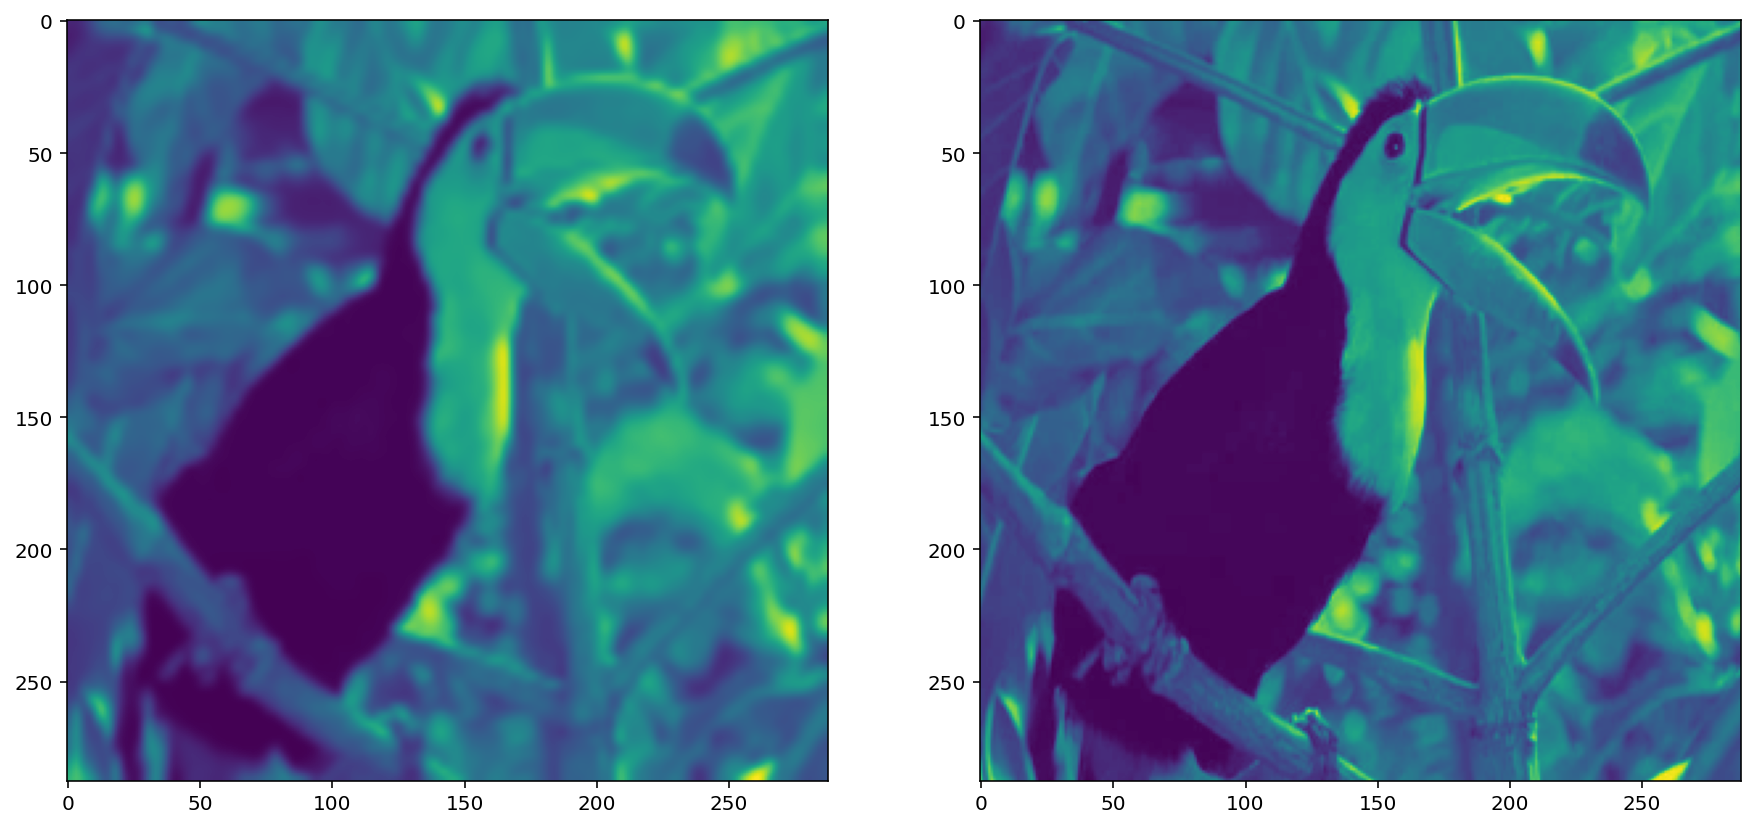

In [55]:
plt.figure(figsize=(15,15))
for i, image in enumerate([input_, label_]):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    print(image.shape)